                                                           Final Machine Learning Project - start2impact - Fabrizio Ferrari

# <center><font size='7'>Data Science Final Project</font></center>

The dataset can be found at: https://drive.google.com/drive/folders/18MMXkE98uHDuWHDgXPpwD08Y7vyEnElk

In this final project, I will analyze and manipulate a dataset containing several factors that affect an airline's passengers satisfaction. The goal is to create a machine learning model that is able to predict passenger satisfaction or dissatisfaction based on their flight experience, and to understand which are the most impacting factors.

This is a supervised binary classification task:

* Supervised: The labels are included in the training data and the goal is to train a model to learn to predict the labels from the features
* Classification: The label is a binary variable, meaning that we define two hypothesis:
    1. satisfied = positive class = 1
    2. neutral or dissatisfied = negative class = 0

<a id="0"></a>
## Table of Contents:

1. [Import and Introductory Data Analysis](#1)\
    1.1 [Loading and read in data](#1.1)\
    1.2 [Check for missing values](#1.2)\
    1.3 [Cataloging the Features, and making related subsets](#1.3)


2. [Exploratory Data Analysis](#2)\
    2.1 [Target variable distribution](#2.1)\
    2.2 [Categorical Features Distribution](#2.2)\
    2.3 [Numerical Features Distribution](#2.3)\
    2.4 [Outlier Detection](#2.4)\
    2.5 [Relations between Features](#2.5)\
    2.6 [Exploratory Data Analysis Conclusion](#2.6)


3. [Data Preprocessing](#3)\
    3.1 [Encoding Categorical Variable](#3.1)\
    3.2 [Scaling the Data](#3.2)\
    3.3 [Preprocessed Dataframe](#3.3)


4. [Correlation with Target and Features Selection](#4)\
    4.1 [Correlation through Chi-Square](#4.1)\
    4.2 [Correlation through ANOVA](#4.2)\
    4.3 [Correlation through Mutual Information](#4.3)\
    4.4 [Feature Selection](#4.4)


5. [Machine Learning: models selection](#5)\
    5.1 [Spot check - Which Algorithms Perform Better?](#5.1)\
    5.2 [Hyperparameter Tuning](#5.2)\
    5.3 [Evaluation of the models on the Test set](#5.3)


6. [Features Importance](#6)


7. [Conclusion](#7)

<a id="1"></a>
# 1. Import and Introductory Data Analysis

In [7]:
# import of the library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
import seaborn as sns
import missingno as msno
import scipy 
import scipy.stats as stats
import math

import random
from random import sample

import category_encoders as ce

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, IsolationForest
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot') # Using ggplot2 style visuals 

<a id="1.1"></a>
## 1.1 Loading and read in data

In [9]:
# load train and test set
df_train = pd.read_csv('../airline_satisfaction/train.csv')
df_test = pd.read_csv('../airline_satisfaction/test.csv')

Training set is big enough to suit for the Exploratory Data Analysis stage, so we keep the 2 sets separated. 

Let's take a look at the first rows using the DataFrame's head() method

In [10]:
df_train.head(2)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied


In [11]:
df_test.head(2)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied


When loading .csv files as dataframes, an index is added to the dataframes, leaving the starting id as a meaningless column ("Unnamed: 0"). The "id" column, on the other hand, refers to the id of the interviewed customer, we will use this column to check for duplicates, and then we will eliminate both as they are usless in predicting the overall satisfaction of the reviewer.

There are 23 attributes 22 of which are the explanatory varibles and 1 is the target variables 'satisfaction'. 

'satisfaction' is a categorical binary variable with labels 'satisfied' and 'neutral or dissatisfied'.

Explanatory columns can be separated by their type:
* **Numerical**: 
  * ***Discrete***:
     * Age: The actual age of the passengers
  * ***Continuous***:
     * Flight Distance: The flight distance of the journey
     * Departure Delay in Minutes: Minutes delayed when departure
     * Arrival Delay in Minutes: Minutes delayed when arrival
* **Categorical**:
  * ***Binary***:
    * Gender: Gender of the passengers (*labels: male, female*)
    * Customer Type: The customer type (*labels: loyal customer, disloyal customer*)
    * Type of travel: Purpose of the flight of the passengers (*labels: personal travel, business travel*)
  * ***Nominal***:
    * Class: Travel class in the plane of the passengers (*labels: eco, eco plus, business*)

  * **Numerical Ordinal** *--->* level of satisfaction expressed by the passengers in a scale ranging between 0-5 (0=Not Applicable, 1=Least Satisfied to 5=Most Satisfied) on a bunch of service provided by the company; can be further separated regard to the sector they refers to:
      * ***Airport Services***:
       * Departure/Arrival_time_convenient: Satisfaction level of Departure/Arrival time convenient
       * Gate_location: Satisfaction level of Gate location
       * Baggage_handling: Satisfaction level of baggage handling
       * Checkin_service: Satisfaction level of checkin service 
      * ***Inflight Services***:
       * Inflight_wifi_service: Satisfaction level of
       * Food_and_drink: Satisfaction level of Food_and_drink
       * Seat_comfort: Satisfaction level of Seat_comfort
       * Inflight_entertainment: Satisfaction level of Inflight_entertainment
       * On-board_service: Satisfaction level of On-board_service
       * Leg_room_service: Satisfaction level of Leg_room_service
       * Inflight_service: Satisfaction level of Inflight_service
       * Cleanliness: Satisfaction level of Cleanliness
      * ***Online Services***:
       * Ease_of_Online_booking: Satisfaction level of Ease_of_Online_booking
       * Online_boarding: Satisfaction level of Online_boarding

The info() method is useful to get a quick description of the data, in particular the total number of rows, each attribute's type and the number of non-null values.

In [12]:
# Check the size of data and presence of null values - train set
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [13]:
# Check the size of data and presence of null values - test set
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25976 entries, 0 to 25975
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         25976 non-null  int64  
 1   id                                 25976 non-null  int64  
 2   Gender                             25976 non-null  object 
 3   Customer Type                      25976 non-null  object 
 4   Age                                25976 non-null  int64  
 5   Type of Travel                     25976 non-null  object 
 6   Class                              25976 non-null  object 
 7   Flight Distance                    25976 non-null  int64  
 8   Inflight wifi service              25976 non-null  int64  
 9   Departure/Arrival time convenient  25976 non-null  int64  
 10  Ease of Online booking             25976 non-null  int64  
 11  Gate location                      25976 non-null  int

In the training set there are 103,904 entries. The *Arrival Delay in Minutes* attribute has only 103,594 non-null values, meaning that 310 obsarvations are missing this feature.

In the testing set there are 25,976 entries, meaning that we have a dataset of total 129880 observtions, 80% of which are in the training set and 20% in the testing set. The *Arrival Delay in Minutes* attribute has only 25,893 non-null values missing 83 observations.

We can visualize statistics for numerical features with the function describe(), while the categorical are described apart:

In [14]:
# NUMERICAL FEATURES
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,103904.0,51951.500000,29994.645522,0.0,25975.75,51951.5,77927.25,103903.0
id,103904.0,64924.210502,37463.812252,1.0,32533.75,64856.5,97368.25,129880.0
Age,103904.0,39.379706,15.114964,7.0,27.00,40.0,51.00,85.0
Flight Distance,103904.0,1189.448375,997.147281,31.0,414.00,843.0,1743.00,4983.0
Inflight wifi service,103904.0,2.729683,1.327829,0.0,2.00,3.0,4.00,5.0
Departure/Arrival time convenient,103904.0,3.060296,1.525075,0.0,2.00,3.0,4.00,5.0
Ease of Online booking,103904.0,2.756901,1.398929,0.0,2.00,3.0,4.00,5.0
Gate location,103904.0,2.976883,1.277621,0.0,2.00,3.0,4.00,5.0
Food and drink,103904.0,3.202129,1.329533,0.0,2.00,3.0,4.00,5.0
Online boarding,103904.0,3.250375,1.349509,0.0,2.00,3.0,4.00,5.0


In [15]:
# CATEGORICAL FEATURES
df_train.select_dtypes(include='object').describe()

,Gender,Customer Type,Type of Travel,Class,satisfaction
count,103904,103904,103904,103904,103904
unique,2,2,2,3,2
top,Female,Loyal Customer,Business travel,Business,neutral or dissatisfied
freq,52727,84923,71655,49665,58879


From the above, we can see that all the others categorical features are binary exept for *Class* that has three labels. It is interesting to notice that the respondent to the survey are for the vast majority loyal customer and business travellers.

#### Looking for duplicates

Check for duplicates in the dataset and eventually eliminate them

In [16]:
# detect if there any duplicated rows train set
duplicates = df_train.duplicated(subset='id').sum()
if  duplicates == 0:
    print('There is no duplicted rows in train set')
else:
    print('There are: ', str(duplicates), ' duplicates in train set')

There is no duplicted rows in train set


In [17]:
# detect if there any duplicated rows in test set
duplicates = df_test.duplicated(subset='id').sum()
if  duplicates == 0:
    print('There is no duplicted rows in test set')
else:
    print('There are: ', str(duplicates), ' duplicates in test set')

There is no duplicted rows in test set


#### Remove unnecessary columns

In [18]:
# 'Unnamed:0' and 'id' are a dataset artifact, not something useful for analysis so we drop them
df_train = df_train.drop(['Unnamed: 0', 'id'], axis=1)
df_train.head(2)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied


In [19]:
# 'Unnamed:0' and 'id' are a dataset artifact, not something useful for analysis so we drop them
df_test = df_test.drop(['Unnamed: 0', 'id'], axis=1)
df_test.head(2)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,satisfied


#### Replace spaces in the column names with underscore

In [20]:
df_train.columns = [c.replace(' ', '_') for c in df_train.columns]
df_test.columns = [c.replace(' ', '_') for c in df_test.columns]

<a id="1.2"></a>
## 1.2 Check for missing values

Let's verify the presence of missing value

In [21]:
# null values in the traning set
df_train.isnull().sum()

Gender                                 0
Customer_Type                          0
Age                                    0
Type_of_Travel                         0
Class                                  0
Flight_Distance                        0
Inflight_wifi_service                  0
Departure/Arrival_time_convenient      0
Ease_of_Online_booking                 0
Gate_location                          0
Food_and_drink                         0
Online_boarding                        0
Seat_comfort                           0
Inflight_entertainment                 0
On-board_service                       0
Leg_room_service                       0
Baggage_handling                       0
Checkin_service                        0
Inflight_service                       0
Cleanliness                            0
Departure_Delay_in_Minutes             0
Arrival_Delay_in_Minutes             310
satisfaction                           0
dtype: int64

In [22]:
# null values in the testing set
df_test.isnull().sum()

Gender                                0
Customer_Type                         0
Age                                   0
Type_of_Travel                        0
Class                                 0
Flight_Distance                       0
Inflight_wifi_service                 0
Departure/Arrival_time_convenient     0
Ease_of_Online_booking                0
Gate_location                         0
Food_and_drink                        0
Online_boarding                       0
Seat_comfort                          0
Inflight_entertainment                0
On-board_service                      0
Leg_room_service                      0
Baggage_handling                      0
Checkin_service                       0
Inflight_service                      0
Cleanliness                           0
Departure_Delay_in_Minutes            0
Arrival_Delay_in_Minutes             83
satisfaction                          0
dtype: int64

We can also visualize the missing values with the missingo library

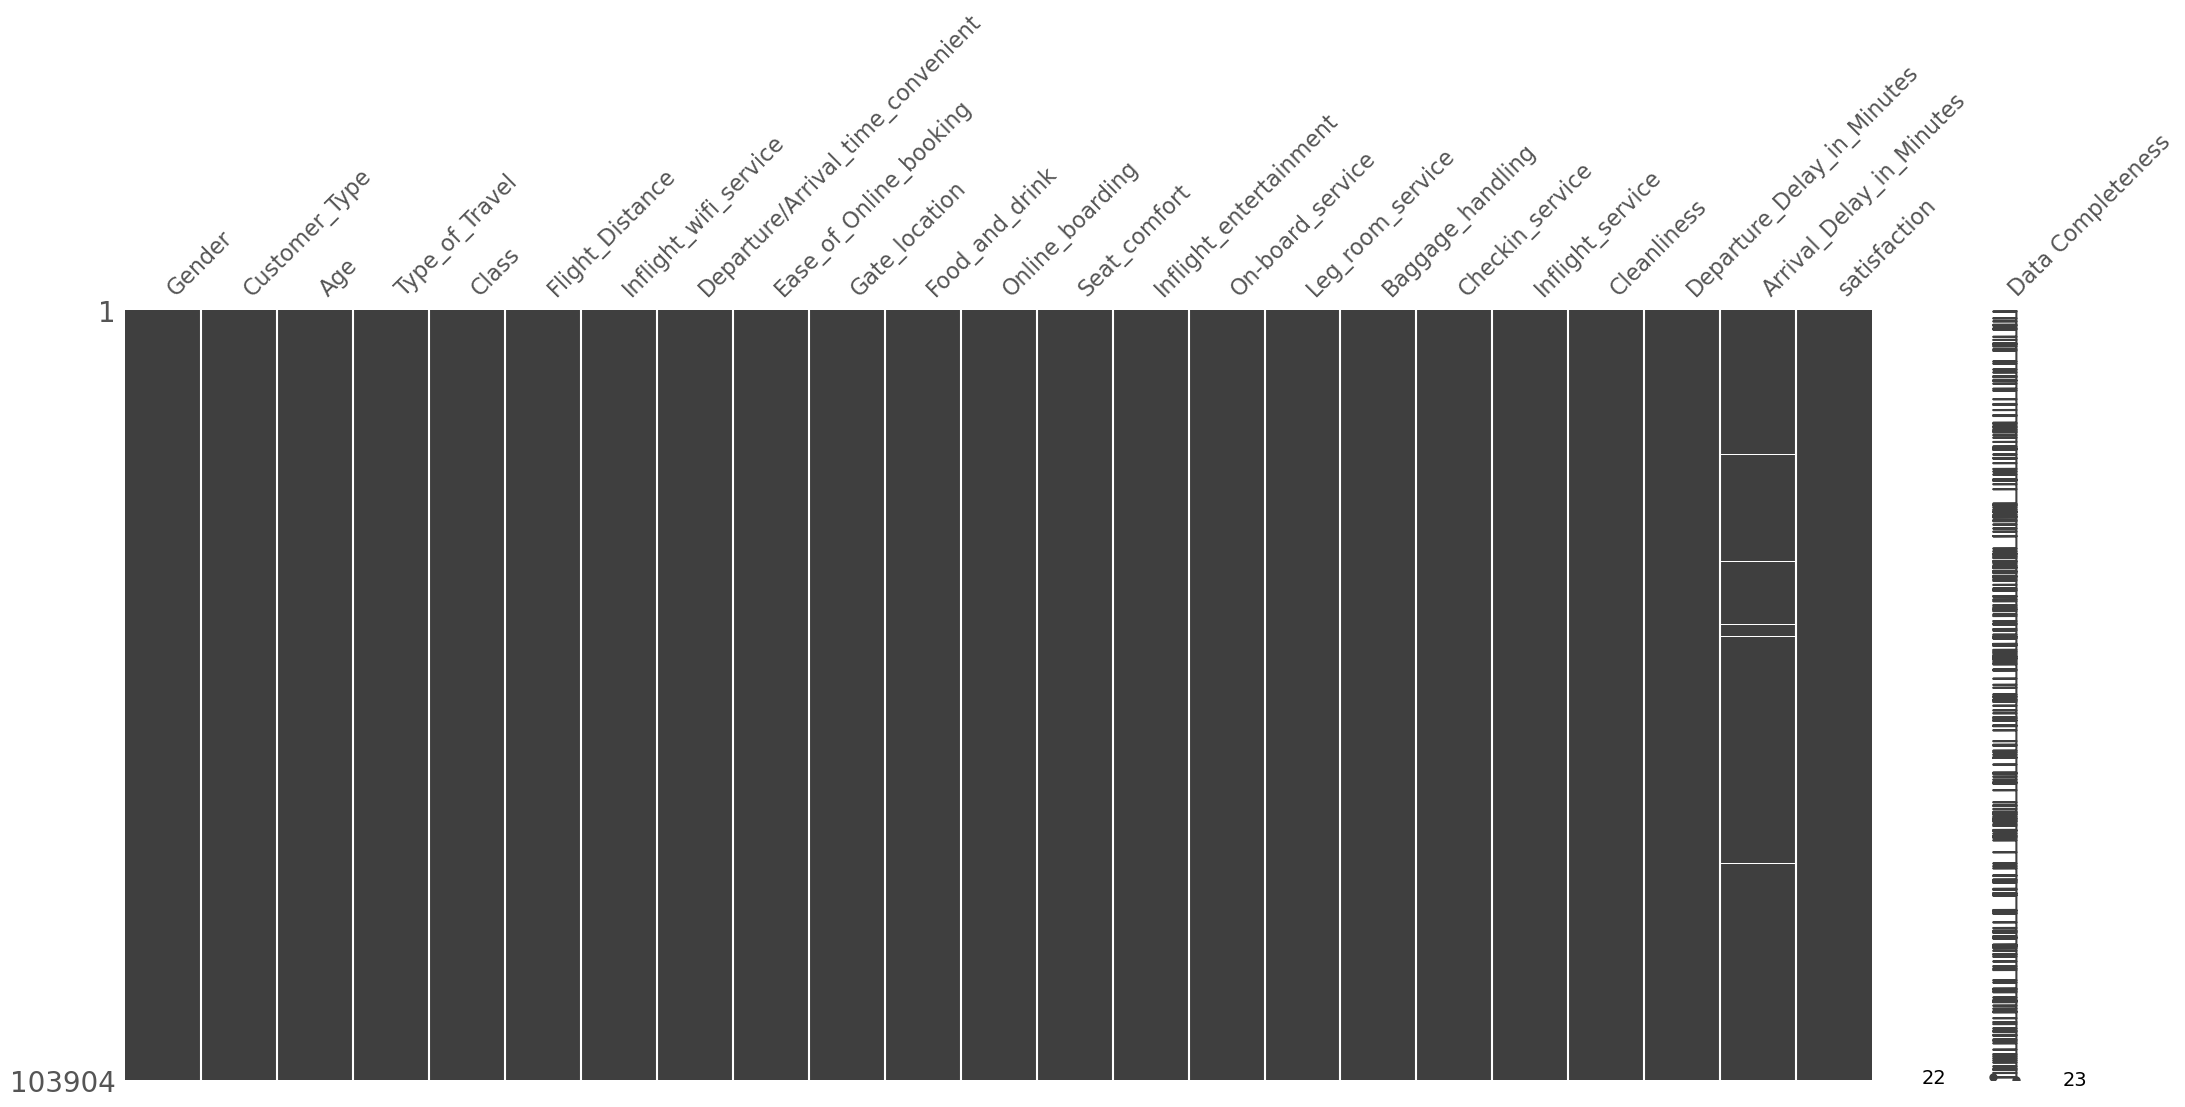

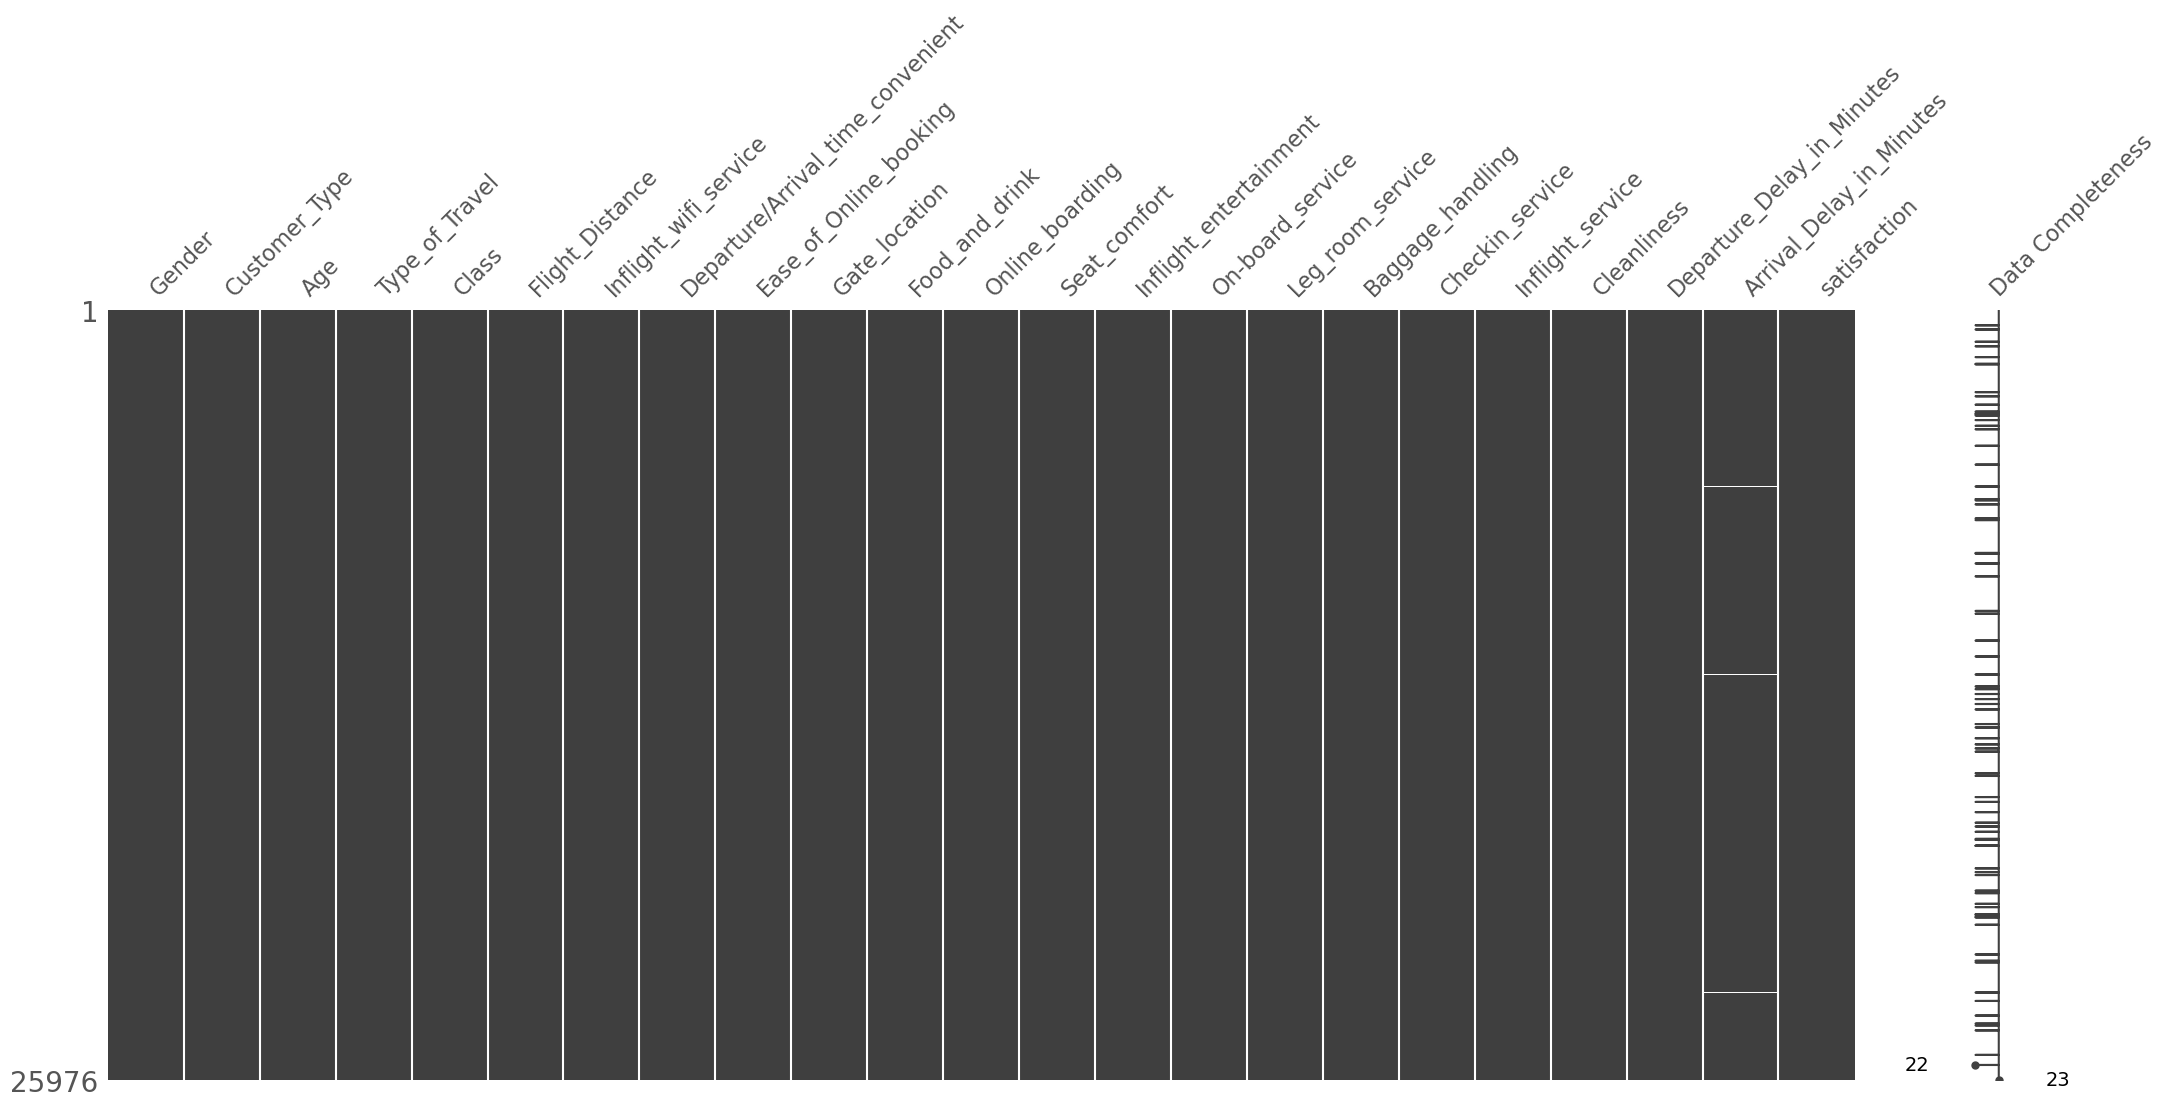

In [23]:
# matrix to visualize missing data
msno.matrix(df_train, labels=True);
msno.matrix(df_test, labels=True);

In [24]:
df_train[df_train.Arrival_Delay_in_Minutes.isnull()] # train subset for missing values

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
213,Female,Loyal Customer,38,Business travel,Eco,109,5,3,3,3,...,5,5,2,4,1,1,5,31,NaN,satisfied
1124,Male,Loyal Customer,53,Personal Travel,Eco,1012,3,2,3,4,...,4,4,4,4,3,3,4,38,NaN,neutral or dissatisfied
1529,Male,Loyal Customer,39,Business travel,Business,733,2,5,5,5,...,2,2,2,2,2,2,3,11,NaN,neutral or dissatisfied
2004,Female,disloyal Customer,26,Business travel,Business,1035,3,3,3,1,...,2,3,3,4,5,5,2,41,NaN,neutral or dissatisfied
2108,Female,Loyal Customer,24,Personal Travel,Eco,417,2,1,2,2,...,5,1,4,2,1,2,5,1,NaN,neutral or dissatisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102067,Male,Loyal Customer,49,Personal Travel,Eco Plus,1249,2,5,2,3,...,3,4,5,4,3,4,3,230,NaN,neutral or dissatisfied
102384,Male,Loyal Customer,58,Business travel,Eco,733,3,3,3,3,...,3,3,1,2,4,2,3,55,NaN,neutral or dissatisfied
102552,Female,disloyal Customer,29,Business travel,Eco,1107,2,1,1,1,...,5,4,1,5,5,3,5,0,NaN,neutral or dissatisfied
102960,Male,Loyal Customer,58,Business travel,Eco,1088,4,4,1,1,...,5,1,5,5,5,3,5,0,NaN,satisfied


In [25]:
df_test[df_test.Arrival_Delay_in_Minutes.isnull()] # test subset for missing values

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
516,Female,Loyal Customer,21,Personal Travel,Eco,632,1,5,1,4,...,2,4,2,5,4,5,2,9,NaN,neutral or dissatisfied
656,Male,Loyal Customer,9,Personal Travel,Eco,762,2,5,2,2,...,4,2,5,2,5,2,4,51,NaN,neutral or dissatisfied
1071,Male,disloyal Customer,25,Business travel,Eco,1017,3,4,4,5,...,5,2,5,2,3,2,5,126,NaN,neutral or dissatisfied
1224,Male,Loyal Customer,7,Personal Travel,Eco,399,4,5,4,4,...,4,4,3,1,1,4,4,0,NaN,neutral or dissatisfied
1589,Female,Loyal Customer,58,Business travel,Eco,129,5,3,3,3,...,5,5,5,5,3,5,5,3,NaN,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24072,Male,Loyal Customer,45,Business travel,Eco,352,5,1,1,1,...,5,1,1,1,3,2,5,26,NaN,satisfied
24133,Female,Loyal Customer,29,Business travel,Business,3873,3,3,3,3,...,3,3,4,4,4,3,3,19,NaN,neutral or dissatisfied
24301,Male,disloyal Customer,38,Business travel,Business,759,3,3,3,1,...,4,3,3,5,5,4,4,0,NaN,satisfied
25128,Female,Loyal Customer,52,Business travel,Business,3659,5,5,5,5,...,5,5,5,5,3,5,3,0,NaN,satisfied


Looking at the data where the missing values occur, there does not appear to be any particular quirks or irregularities, so we can infer that the shortcomings are random and due to chance, most likely due to human or machine error.

In case of random missing values we can fairly priced to delete them, also considering that in our case the frequency of them is insignificant to the number of observations, so we opt for delating them.

In [26]:
# drop null values from train set
df_train = df_train.dropna()

# drop null values from test set
df_test = df_test.dropna()

df_train.shape, df_test.shape

((103594, 23), (25893, 23))

In [27]:
df_train.isnull().sum()

Gender                               0
Customer_Type                        0
Age                                  0
Type_of_Travel                       0
Class                                0
Flight_Distance                      0
Inflight_wifi_service                0
Departure/Arrival_time_convenient    0
Ease_of_Online_booking               0
Gate_location                        0
Food_and_drink                       0
Online_boarding                      0
Seat_comfort                         0
Inflight_entertainment               0
On-board_service                     0
Leg_room_service                     0
Baggage_handling                     0
Checkin_service                      0
Inflight_service                     0
Cleanliness                          0
Departure_Delay_in_Minutes           0
Arrival_Delay_in_Minutes             0
satisfaction                         0
dtype: int64

<a id="1.3"></a>
## 1.3 Cataloging the Features, and making related subsets

In [28]:
# categorical features
categ_features_df = df_train.select_dtypes(include='object')
categ_features_df.head(2)

,Gender,Customer_Type,Type_of_Travel,Class,satisfaction
0,Male,Loyal Customer,Personal Travel,Eco Plus,neutral or dissatisfied
1,Male,disloyal Customer,Business travel,Business,neutral or dissatisfied


For ordinal and numerical features, we first create a variable with the indexes of the features then create the dataframe selecting those indexes.

In [29]:
ordinal_indexes = list(range(6, 20)) # index of ordinal features

ordinal_feat_df = df_train.iloc[:, ordinal_indexes] # subset of ordinal features

ordinal_feat_df.head(2)

,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness
0,3,4,3,1,5,3,5,5,4,3,4,4,5,5
1,3,2,3,3,1,3,1,1,1,5,3,1,4,1


In [30]:
# numerical features
num = df_train.select_dtypes(include='number').nunique()>6
num_col = num[num].index # list of numerical columns

num_feat_df = df_train.loc[:, num_col] # subset for numerical columns
num_feat_df.head(2)

,Age,Flight_Distance,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes
0,13,460,25,18.0
1,25,235,1,6.0


<a id="2"></a>
# 2. Exploratory Data Analysis
[Back to Table of Content](#0)

<a id="2.1"></a>
## 2.1 Target variable distribution

We will first look at the target variable *satisfaction* by plotting the labels distribution either through a barplot and a donut chart.

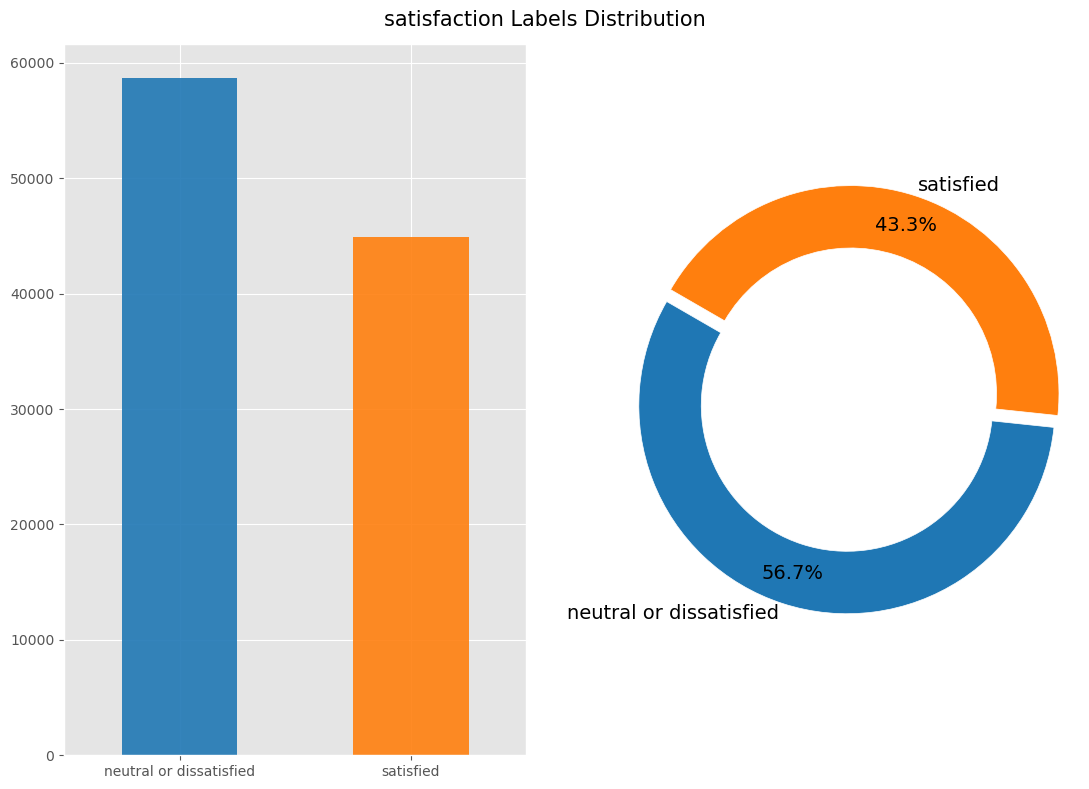

In [31]:
# plot target variable
plt.figure(figsize=(11, 8)) # set figure size

explode = [.03 for x in range(len(df_train.satisfaction.unique()))] # set explode dim for labels
labels = [df_train.satisfaction.unique()[i] for i in range(len(df_train.satisfaction.unique()))] # labels
c_palette = ['tab:blue', 'tab:orange'] # setting specific color palette

plt.subplot(1, 2, 1) # first plot barchart showing labels distribution
df_train.satisfaction.value_counts().plot(kind='bar', color=c_palette, alpha=0.9, rot=0)

plt.subplot(1, 2, 2) # second plot: pie chart showing labels frequency
plt.pie(df_train.satisfaction.value_counts(), radius=1, labels=labels, autopct='%1.1f%%', 
        wedgeprops=dict(width=.3, edgecolor='w'), textprops={'fontsize':14}, pctdistance=.85,
        labeldistance=1.05, startangle=150, explode=explode, colors=c_palette)
plt.axis('equal')


plt.suptitle(f'satisfaction Labels Distribution', fontsize=15) #set superior title
plt.tight_layout()
plt.show()

The above plots shows a distribution of 56.7%:43.3% between neutral/dissatisfied passengers and satisfied passengers respectively. So the data is quite balanced and it does not require any special treatment/resampling.

We can see that more than half of the customers are dissatisfied, in the following we will try to understand which characteristics are influencing the result the most.

<a id="2.2"></a>
## 2.2 Categorical Features Distribution 

After the target we proceed our analisys looking at the distribution of the categorical variables. 

We will make a function that plot a donut plot for each category features. The function first calculate the fraction of unique values and compare it to the threshold max_fraction_unique to verify if the input column is categorical and could be ploted; if the fraction is higher than the threshold the function return an advise and stop, otherwise it proceed to the plotting process:
1. cat_col_labels: labels name of the columns
2. explode_bin: explosion intensity for each label
3. size: size of the center of the donut
4. all_colors: color palette
5. colors: sample number of color according to the number of labels
6. make the donut plot
7. set title of the plot

In [25]:
def donut_plot(X, cat_col, max_fraction_unique=0.05):
    '''
    Show the distribution of the categorical variable's labels through a donut plot.
    X: pd.DataFrame, dataframe to remove categorical features from.
    
    :cat_col_labels: labels name of the columns
    :explode_bin: explosion intensity for each label
    :size: size of the center of the donut
    :all_colors: color palette
    :colors: sample number of color according to the number of labels
    
    Return: If the variable is not categorical return Error.    
    '''
    
    fraction_unique = len(X[cat_col].unique())/len(X[cat_col])
    
    if fraction_unique > max_fraction_unique:
        
        return 'Error: too many labels to plot, probably not a categorical variable'
    
    else:
        cat_col_labels = X[cat_col].value_counts().index.tolist() # selecting labels from column
        explode_bin = [.03 for x in range(len(X[cat_col].unique()))] # explosion intensity according to number of labels
        size = 0.3 # size of the center for donut graph
        all_colors = [k for k,v in pltc.cnames.items()] # selecting color palette

        for val in range(1):
            colors = sample(all_colors, len(cat_col_labels)) # sampling number of colors from all_colors:#colors=#labels
            plt.pie(X[cat_col].value_counts(), labels=cat_col_labels, radius=1, colors=colors,
                        autopct='%1.1f%%', textprops={'fontsize':14}, wedgeprops=dict(width=size, edgecolor='b'),
                       pctdistance=.55, labeldistance=1.05, explode=explode_bin, startangle=-30)
            plt.axis('equal') # assure perfectly circle

        plt.title(f'{cat_col}\ndistribution', fontsize=20) #set subplot titles

Now we call the donut_plot function with the categorical variables as input, excluding the satisfaction column which we have already looked at.

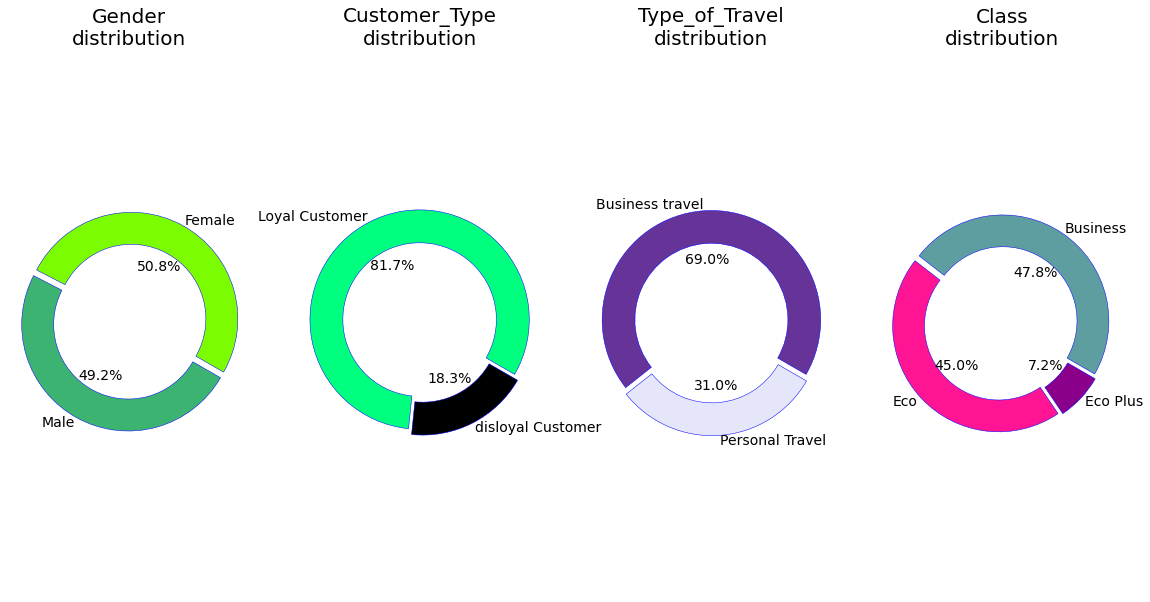

In [26]:
random.seed(5) # initialising pseudorandom state at 5

fig = plt.figure(figsize=(20, 10)) # setting figure dimension


# setting subplot axes
a = 1  # number of rows
b = 4  # number of columns
c = 1  # initialize plot counter


for cat_col in categ_features_df.columns[:-1]:
    plt.subplot(a, b, c)
    donut_plot(df_train, cat_col, max_fraction_unique=0.01)
    c += 1
    
# plt.tight_layout()

We can see that:
* Gender is equally rappresented
* There is a majority presence of loyal customer, business travel and business class

<a id="2.3"></a>
## 2.3 Numerical Features Distribution

We want to verify if numerical data are normally distributed, and the presence of outliers.

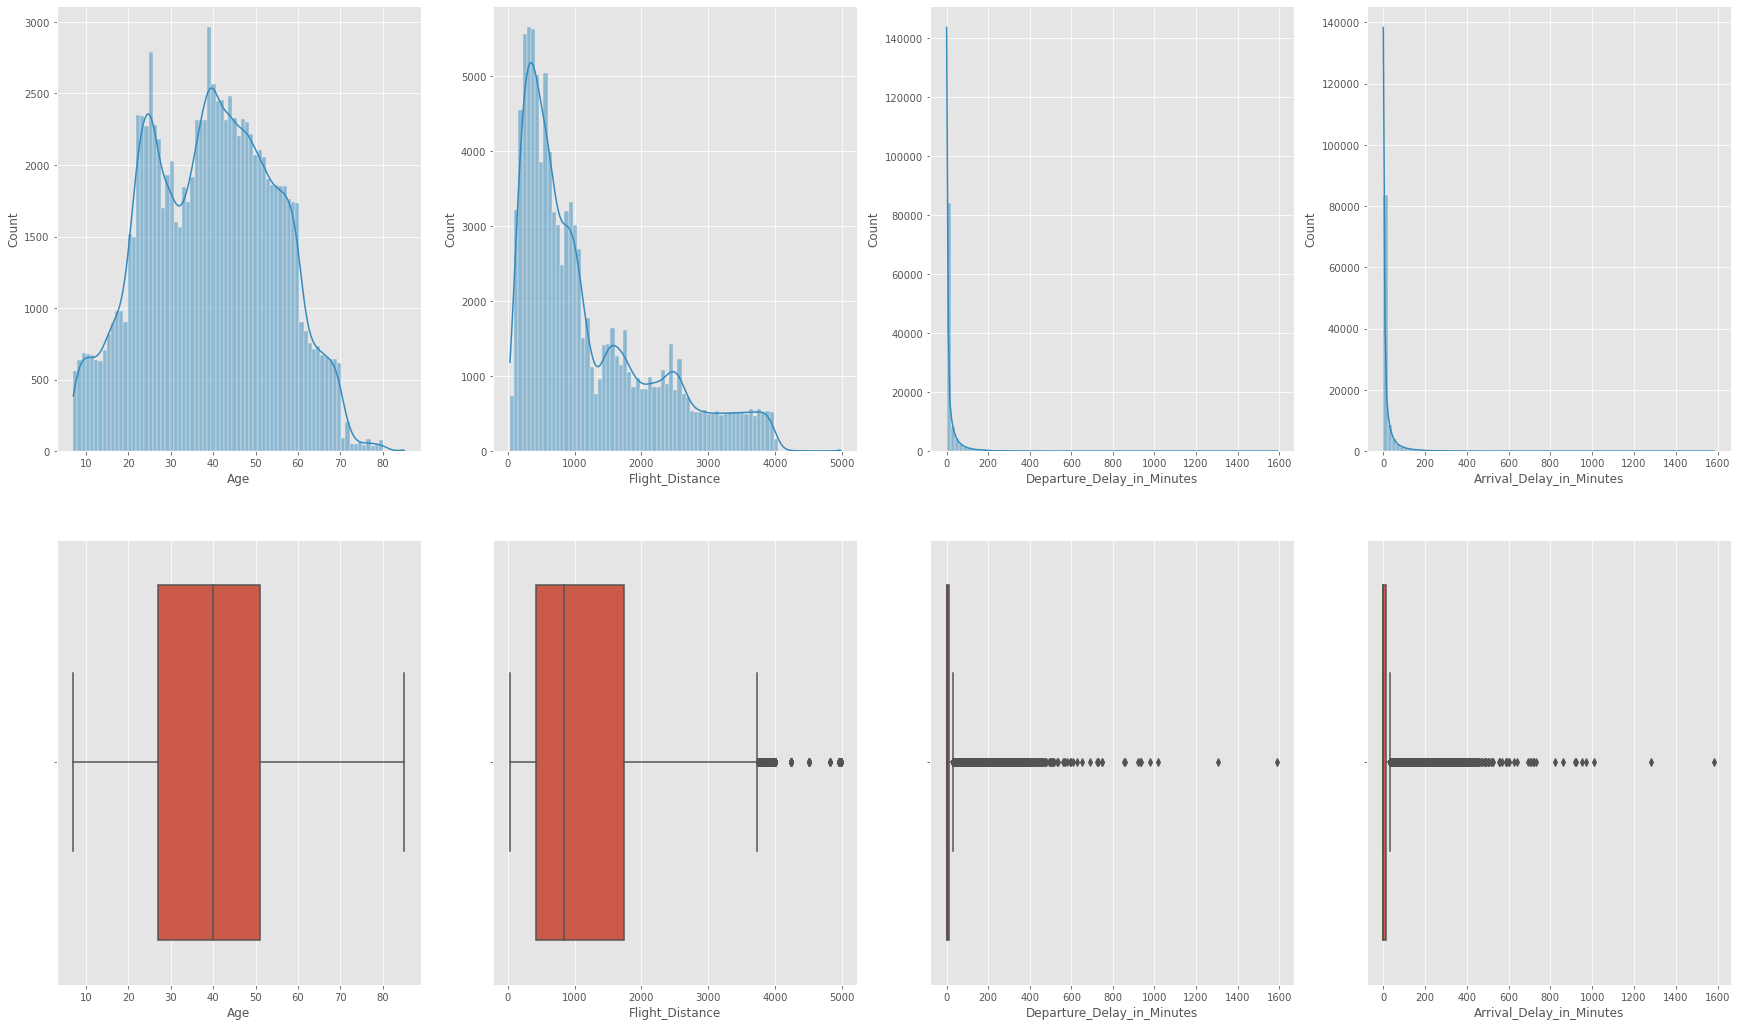

In [27]:
# setting subplot axes
a = 2  # number of rows
b = 4  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(30, 18))

#  ploting Numerical Data 
for i in num_col:
    plt.subplot(a, b, c)
    sns.histplot(data=df_train, x=df_train[i], bins=79, kde=True) # first col subplot: hist with proper number of bins

    plt.subplot(a, b, c+4)
    sns.boxplot(x=df_train[i], data=df_train) # second col subplot: boxplot
    c += 1
    
plt.show()

**Age** variable is predictably distributed, with an uniformly presence of passengers in the range from 7 to 70 years old.

**Flight_Distance** indicates that most flights are domestic (under 1000 miles; median is 842.0), it is right skewed with the presence of outliers.

**Delay features** have very similar distribution, are extrimelly right skewed whith a strong presence of outliers. I would argue anyway, that the shape of the two variables is the normal standard that we can observe empirically, where delay are (hopefully) rare or even extrimly rare's, then I won't consider those observations as anomaly or outliers, at least up to a certain threshold

Let's see the level of correlation between the features

In [28]:
# numerical features correlation matrix
corr = num_feat_df.corr()

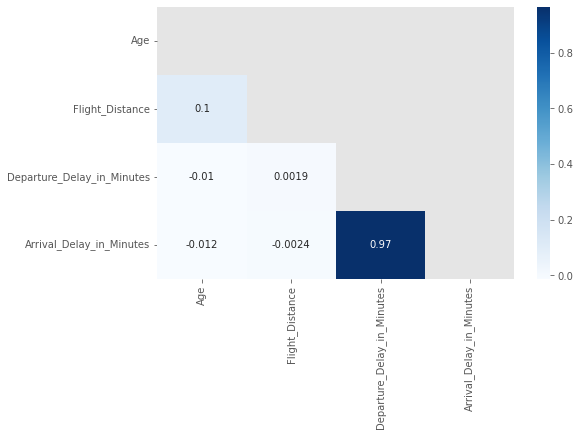

In [29]:
plt.figure(figsize=(8, 5)) # set figure dimension

# mask
mask = np.triu(np.ones_like(corr, dtype=bool))
# adjust mask and df
# mask = mask[1:, :-1]
# corr = df_corr.iloc[1:,:-1].copy()

# plot the heatmap
sns.heatmap(corr, mask=mask, annot=True, cmap='Blues')

plt.show()

How we can see the correlation between **Departure Delay in Minutes** and **Arrival Delay in Minutes** is very high (0.97). That makes sense. If the plane leaves later than expected, it should arrive later as well. 
The level of correlation is next to 1 meaning that these features are redundant; we will evaluate to delete one of them later.

<a id="2.4"></a>
## 2.4 Outlier Detection

For various reasons, such as: measurement or input errors; data corruption; true outliers observations; datasets can contain extreme values that are outside of the range of the majority of the data. These observations are called outliers. Outliers can skew statistical measures and data distributions, providing a misleading representation of the underlying data and relationships. While removing outliers from training data prior to modeling may result in a better fit of the data and, in turn, more proficient predictions, if the outliers in our data are not due to errors but only a natural variation from the most of the population sample, deleting them could be a mistake as they are part of our distribution and can instead provide useful information. Therefore, it is important to understand their nature before removing.

Moreover, identify and remove outliers can be difficult especially when we are in the presence of a large number of input values, and statistical method like Standard Deviation and Interquartile Range methods result to bee to simple and unable to detect complex and unknown inter-relationship between the data. Instead, automatic outlier detection methods can be used in the modeling pipeline and compared, just like other data preparation transforms that may be applied to the dataset.

For the identification of outliers and eventually removal, we will proceed according to the following workflow:
1. Plot the data and analyse features which present outliers
2. Create a baseline model performance
3. Use different method of automatic outliers detection and compare results. The method we will use are:
   * **Isolation Forest**:
     Is a tree-based anomaly detection that model the data in such a way as to isolate anomalies that are both low in number and differente in the feature space, e.g samples in early leaves of the trees are presumably outliers, because they differ quickly from the mass.
   * **Minimum Covariance Determinant**: this approach is based on statistical method applied in the multidimensional space shaped by the data and data that falls outside this shape is considered outliers.

To have a quick glance to the presence of outliers visually the go to way is boxplot. In this case outliers are individuated statistically through the IQR (Interquartile Range), i.e. in a boxplot outliers are those point that are more extreme than the extreme values (maximum and minimum) represented by the wisker of the box, this values obtained according the following formula max=Q3+1.5IQR; min=Q1-1.5IQR, were Q3 and Q1 are respectively the third and the first quartile and IQR=Q3-Q1. 

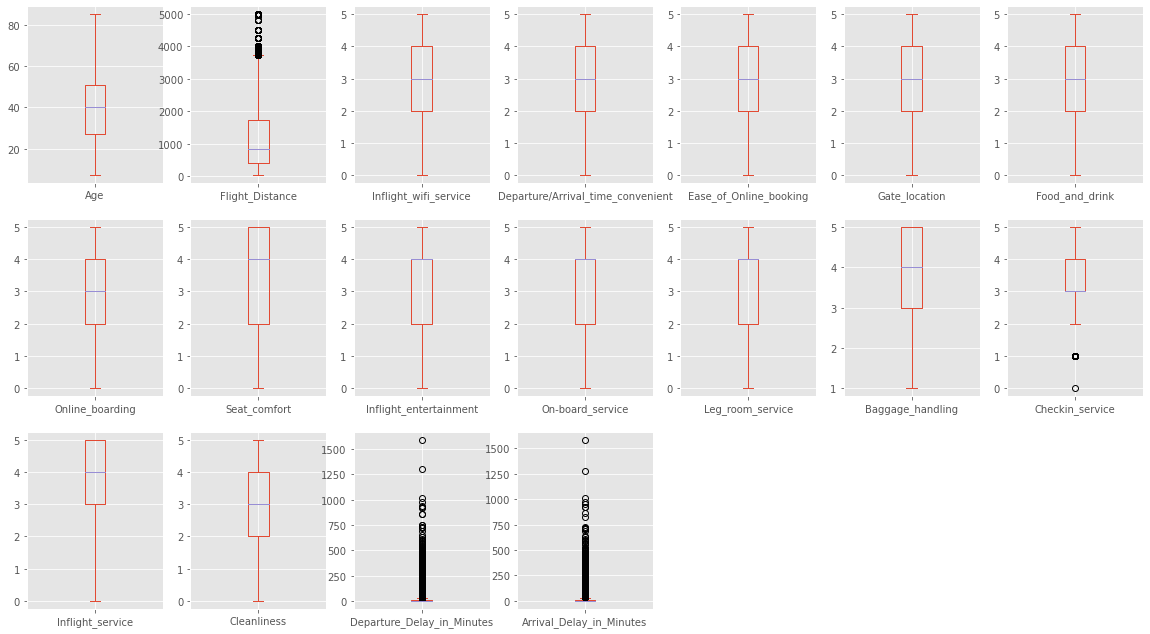

In [30]:
#check outliers
df_train.plot(kind = "box" , subplots = True , figsize = (20,15) ,  layout = (4,7))
plt.show()

As we have already seen only three columns, Flight Distance, Departure/Arrival Delay in Minutes, has outliers

We can also use others plots like the below stripplot to have a more detalied visualization.

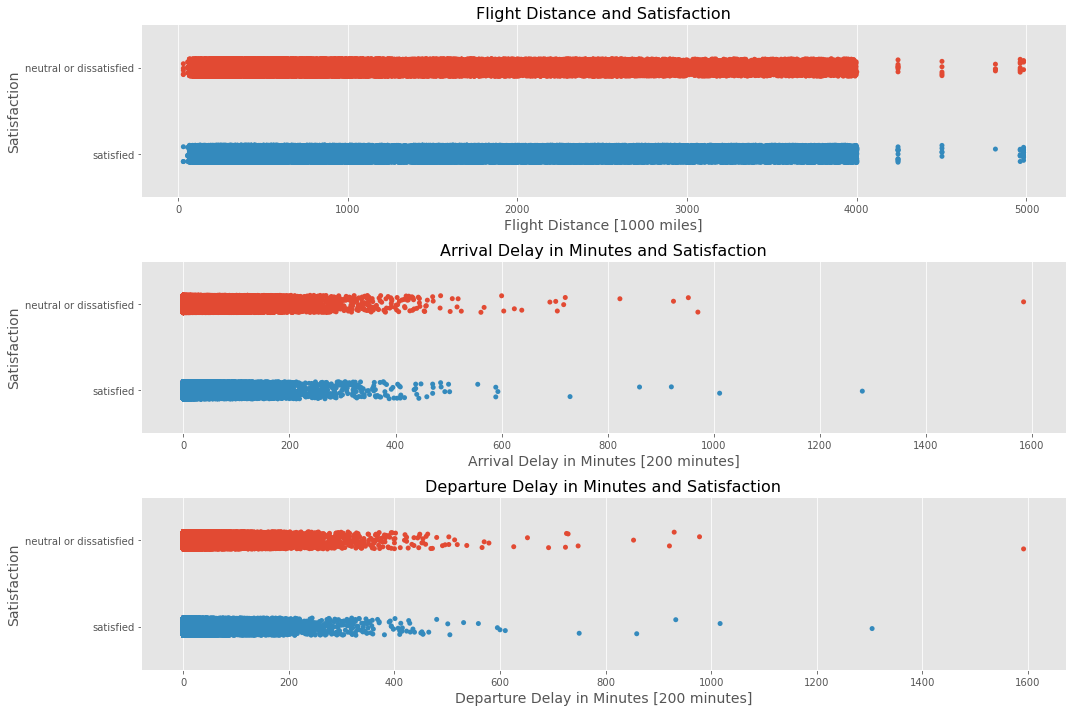

In [31]:
# defining the size of the figure
plt.figure(figsize=(15, 10))


plt.subplot(311)
# plotting the scatterplot 
sns.stripplot(data=df_train, x='Flight_Distance', y='satisfaction')

# labeling
plt.title(f'Flight Distance and Satisfaction', fontsize=16) #plot TITLE
plt.xlabel('Flight Distance [1000 miles]', fontsize=14) #x-axis label
plt.ylabel('Satisfaction', fontsize=14) #y-axis label


plt.subplot(312)
#p lotting the scatterplot 
sns.stripplot(data=df_train, x='Arrival_Delay_in_Minutes', y='satisfaction')

# labeling
plt.title(f'Arrival Delay in Minutes and Satisfaction', fontsize=16) #plot TITLE
plt.xlabel('Arrival Delay in Minutes [200 minutes]', fontsize=14) #x-axis label
plt.ylabel('Satisfaction', fontsize=14) #y-axis label


plt.subplot(313)
# plotting the scatterplot 
sns.stripplot(data=df_train, x='Departure_Delay_in_Minutes', y='satisfaction')

# labeling
plt.title(f'Departure Delay in Minutes and Satisfaction', fontsize=16) #plot TITLE
plt.xlabel('Departure Delay in Minutes [200 minutes]', fontsize=14) #x-axis label
plt.ylabel('Satisfaction', fontsize=14) #y-axis label

plt.tight_layout()
plt.show()

From the above plots it is clear that the anomalies present in our data are not due to errors, but a natural, even if rare, variations from the central tendency of the distribution. For this reason I believe there is no reason to delete them.

In any case, I test empirically through Isolation Forest, an automatic outlier detection method, if removing the anomalies would give our prediction better accuracy. To have a point of reference with respect to the level of performance before and after the elimination of the outliers, we set up a basic model trained on all the data.

### Baseline Model Performance

It is a binary classification predictive modeling problem, meaning that we will be predicting a binary label positive or negative.

We first create a copy of the data thne make the preprocessing needed to get the data type numerical and standadized, then fit a Random Forest Classifier algorithm, and evaluate the model performance by a 5-fold cross validation.

As metric to evaluate performance we use accuracy.

This baseline model will be use to compare the prediction performance from the models fitted on the outlier free datasets.

In [32]:
# Creating a copy of the train dataset
encoded_df = df_train.copy()
encoded_df.head(2)

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied


In [33]:
encoded_df['satisfaction'].replace({'neutral or dissatisfied':0, 'satisfied':1}, inplace=True) # encoding target

# separate predictors from target
X_out, y_out = encoded_df.iloc[:, :-1], encoded_df.iloc[:, -1:]

In [34]:
numeric_features = list(encoded_df.select_dtypes(include='number').columns[:-1]) # list of numerical features
categorical_features = list(categ_features_df.columns[:-1]) # list of categorical features

preprocessor = ColumnTransformer(
transformers=[
    ('num', MinMaxScaler(), numeric_features), # normalizing numerical features
    ('cat', OneHotEncoder(), categorical_features)]) # encoding cat features

pipe = Pipeline(steps=[('preprocessor', preprocessor)])

X_out = pipe.fit_transform(X_out) # predictors preprocessing

model = RandomForestClassifier() # difine model

# Evaluating with cross validation
out_cross_score = cross_val_score(model, X_out, y_out, cv=5, n_jobs=-1)
print(f'All data cross val acc: {out_cross_score}\nAll data mean: {out_cross_score.mean()}')

All data cross val acc: [0.9613881  0.96327043 0.96071239 0.96389787 0.9646684 ]
All data mean: 0.9627874382779504


### Isolation Forest Outliers Detections

The parameter "contamination" in Isolation Forest is one of the most important and indicate the proportion of outliers in the dataset, it has to be setted during fitting to define the threshold on the score of the samples. The default setting is 'auto' but could be set as a float range between (0, 0.5].

In [35]:
# Call an istance of isolationforest with contamination of 0.05
iso = IsolationForest(contamination=0.05, n_jobs=-1, random_state=42)

# prediction on the train set
yhat = iso.fit_predict(X_out)

The prediction result in an array of same lenght of the dataset marking each row as normal (1) or an outlier (-1).

Now we proceed to store the unique value (i.e. -1 for outliers and 1 for inliers) and the relative counts of the prediction in two separate numpy arrays.

Then create a dataframe with the two array as columns and print it to the console.

In [36]:
unique, counts = np.unique(yhat, return_counts=True) # selecting unique values and relative counts of the prediction
uniq_count = np.column_stack((unique, counts)) # stacking yhat unique values -1 and 1 to each number of occurrence 

# dataframe summarizing number of outliers and inliers
out_sum_df = pd.DataFrame(uniq_count, columns=['mark', 'number_of_observations'], index=['outlier', 'inlier'])


print(f'Length of the training set: {encoded_df.shape[0]}\nLength of the predictions array: {yhat.size}')
display(out_sum_df)

Length of the training set: 103594
Length of the predictions array: 103594


,mark,number_of_observations
outlier,-1,5180
inlier,1,98414


In [37]:
X_iso = X_out.copy() #  copy dataset and assign to a new variable
X_iso.shape

(103594, 27)

Now we proceed to select only the inlier observations in the variable mask and pass it to the X_iso dataframe just created to retain only those observations in it.

In [38]:
mask = yhat != -1 # select inlier observations

X_iso, y_iso = X_iso[mask], y_out[mask] # deleting outliers 
X_iso.shape, y_iso.shape # summarize the shape of the updated training dataset

((98414, 27), (98414, 1))

Once we have eliminated the outliers from the traning set, we can proceed to fit the model to the data and make the prediction so we can compere the result with the baseline model.

In [39]:
# Evaluating with cross validation
iso_cross_score = cross_val_score(model, X_iso, y_iso, cv=5, n_jobs=-1)
print(f'Iso forest cross val acc: {iso_cross_score}\nMean Iso forest cross val acc: {iso_cross_score.mean()}')

Iso forest cross val acc: [0.96169283 0.96301377 0.9604227  0.96418229 0.9643837 ]
Mean Iso forest cross val acc: 0.9627390579047994


We can see that the elimination of outliers does not provide better accuracy. Based on the considerations made, I can conclude that it is better to leave the outliers

<a id="2.5"></a>
## 2.5 Relation between Features
[Back to Table of Content](#0)

### Age vs Satisfaction

Let's first analyze distribution of age respect to each labels of target variable. We want to see if there is a relation between age and target.

We will use the displot() Seabron function to visualize the data with the parameter kind set to kde.

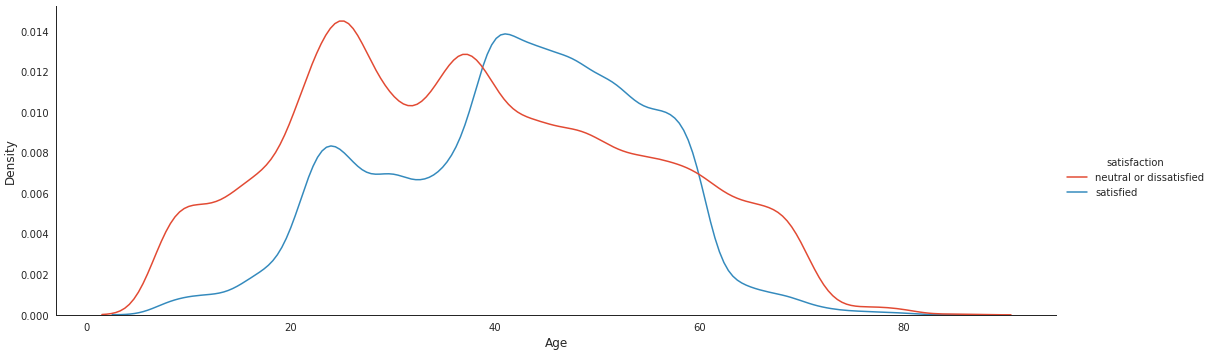

In [40]:
with sns.axes_style('white'):
    g = sns.displot(x='Age', data=df_train, hue='satisfaction', aspect=3.0, kind='kde')

The range of **Age** variable goes from 7 up to 85 years old. We can see that from age 7 to 38 and from age 61 to the end, quotient of neutral or dissatisfied passengers is higher compared to satisfied passengers. On the contrary, in age range 39-60, quotient of satisfied passengers is higher compared to dissatisfied passengers. The presence of well-defined preferences between age groups, may makes the variable relevant in predicting the target.

Now we will esamine the composition of Age among Type_of_Travel and Class always respect to the target variable. What we want to see is how the age is distributed through out this two variable and which is the level of satisfaction in each cluster.

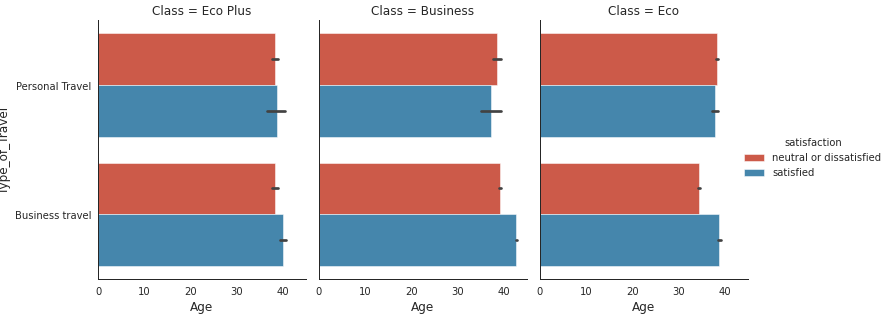

In [41]:
with sns.axes_style(style='white'):
    g = sns.catplot(x='Age', y='Type_of_Travel', data=df_train, hue='satisfaction', col='Class',
                   kind='bar', height=4.5, aspect=.8)

We can see that in the Business Travel category, for every type of class, the average age is always higher than that of Personal Travel and satisfaction is always higher than dissatisfaction. For personal travel, satisfaction is always lower with the exception of the Eco Plus class. It is interesting to notice that, for Personal Travel, the satisfaction/dissatisfaction count is always very similar, with the exception of Business Class were is a bit more marked; for Business Travel the difference is always more marked

### Flight Distance

For Flight_Distance we whant to visualize the relation between distance of the flight and satisfaction.

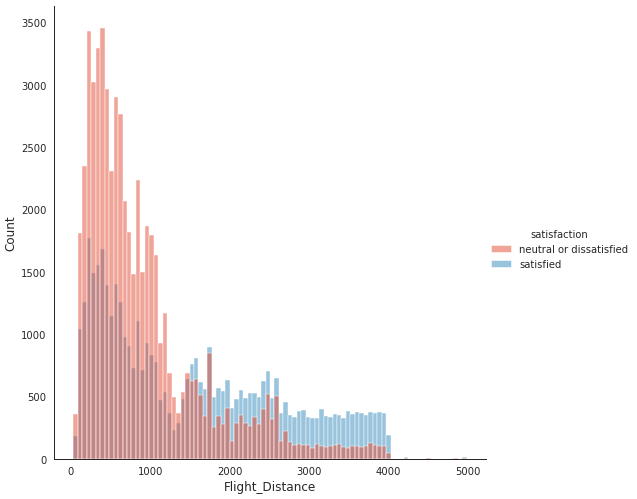

In [42]:
with sns.axes_style('white'):
    g = sns.displot(x='Flight_Distance', data=df_train, hue='satisfaction', height=7, aspect=1)

Flight distance show that the longer is the flight the higher is the frequency of satisfaction between passengers.

We can identify two distinct trends:

1. 0 to 1500 miles dissatisfaction is always higher
2. from 1501 to 4000 satisfaction is always higher

Let's see how flight distance behave respect class and type of travel:

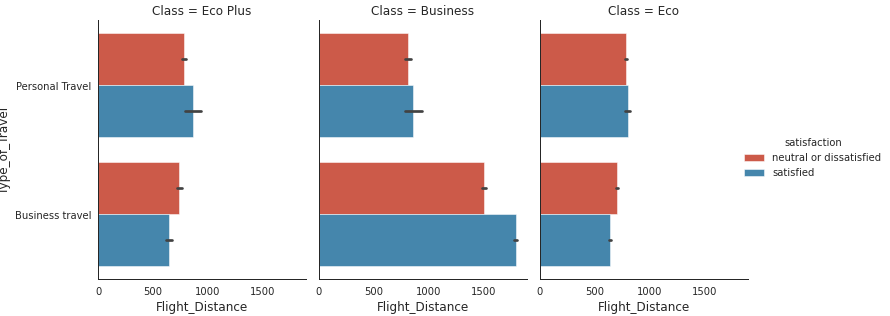

In [43]:
with sns.axes_style(style='white'):
    g = sns.catplot(x='Flight_Distance', y='Type_of_Travel', data=df_train, hue='satisfaction', col='Class',
                   kind='bar', height=4.5, aspect=.8)

From the above plot we can see two important aspect of the data:
1. business travel are more frequent on longer flight
2. satisfation rate increase in longer flight

For business travel in business class category, the number of satisfied passengers are quite on the higher side for longer flight distance. For other combinations, there is almost equal distribution of satisfied and dissatisfied passengers.

Analysis of *Flight Distance* show that there is a clear tendency due to which the longer is the flight the higher is the satisfaction of passengers. Furthermore, from the last plot we can see that longer flight belong to business travel in business class.

I would argue that the variable Flight_Distance matter to the target

### Gender vs Satisfaction

We whant to know how satisfaction is distributed among gender using a catplot function with the paramenter kind set to count so that a countplot will be displayed. On the x axis we will have the target column, and the plot will visualize the count of each label. We will display a plot for each Gender label, setting paramenter col equal to 'Gender'.

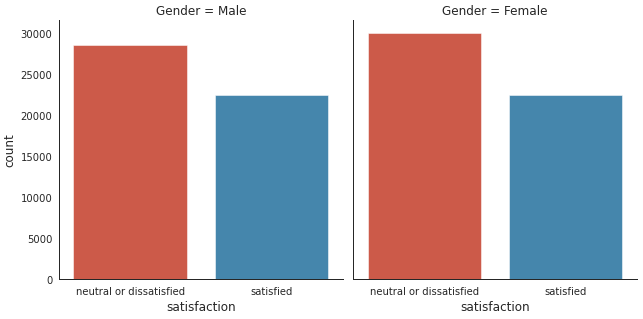

In [44]:
with sns.axes_style(style='white'):
    g = sns.catplot(x='satisfaction', col='Gender', col_wrap=2, data=df_train, kind='count', height=4.5, aspect=1.0)

**Gender**-wise distribution of dissatisfied and satisfied customers are quite the same. For both male and female passengers, number of dissatisfied customers are on the higher side compared to number of satisfied customers.

This feature doesn't seems to be effective respect to the satisfaction of the customers

### Class and Satisfaction

Now we want to investigate the relationship between the Class column and the target column, in particular we want to understand how the percentage of satisfaction and dissatisfaction varies between classes. We will also analyze the Class variable with respect to the likert columns to check the average of the votes received by each service as the class changes. This data could be useful for airlines to understand which services are deemed most important by their customers and how this perception varies according to the class.

Let's first analyse the relation between Class and satisfaction.

We will use a catplot with kind parameter set to count, the column satisfaction on the x axis and the parameter col set to the column Class.

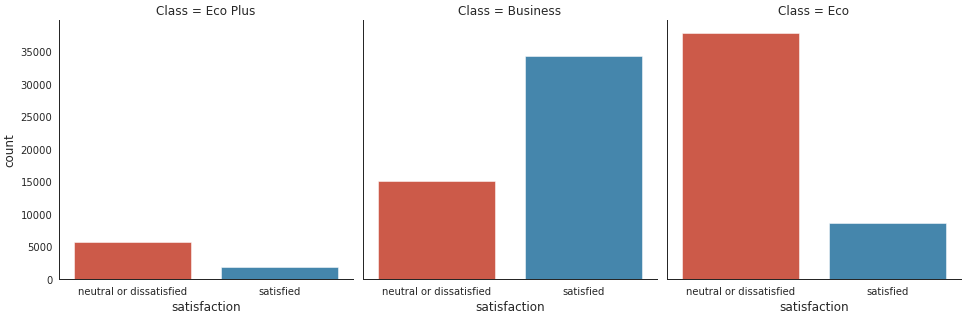

In [45]:
with sns.axes_style(style='white'):
    g = sns.catplot(x='satisfaction', col='Class', col_wrap=3, data=df_train, kind='count', height=4.5, aspect=1.0)

Business and Eco are similar in number higher than Eco plus. Among Business class, the ratio of satisfied is much higher than dissatisfied ones, we have the opposite for Eco classes, where dissatisfied are much higher than satisfied ones.

### Customer Type - Type of Travel

We want to see now the composition of the surveyed passengers and the relation of each class with the target. 
We examine the composition and the relation with the target of both the single variables as of the aggregated variables.

Let's first examine the composition of the Customer_Type variable and its relation with the target:

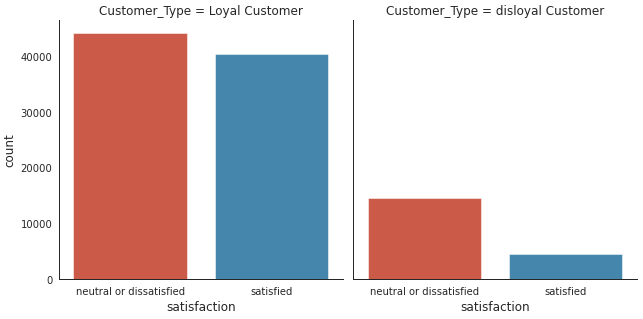

In [46]:
with sns.axes_style(style='white'):
    sns.catplot(x='satisfaction', col='Customer_Type', data=df_train, kind='count', height=4.5, aspect=1.0);

Loyal passengers are very high in number. Among loyal passengers, the ratio of satisfied and dissatidfied ones are almost 49:51.

Let's analyze the same plot for the variable Type_of_travel:

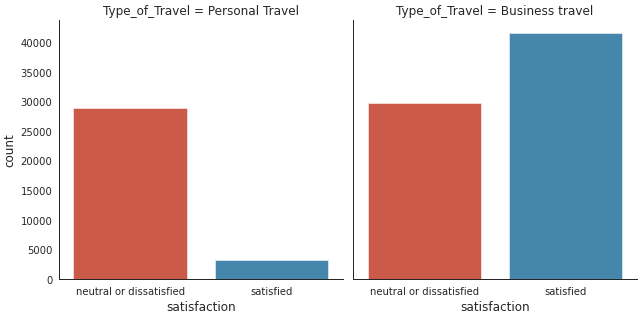

In [47]:
with sns.axes_style(style='white'):
    sns.catplot(x='satisfaction', col='Type_of_Travel', data=df_train, kind='count', height=4.5, aspect=1.0);

Business Travel are very high in number. Among business travel, the ratio of satisfied is much higher than dissatidfied ones.

To have more details in the composition of the passengers, we now group observations by **Customer Type and Type of Travel**,we want to know the frequency of each cluster of passengers.

With the pandas function crosstab() we create a pandas dataframe, with the column Customer_Type as index and Type_of_Travel as column, values are the count of each cluster of passengers.

In [48]:
grouped = pd.crosstab(df_train.Customer_Type, df_train.Type_of_Travel, normalize=True).round(3)
grouped

Type_of_Travel,Business travel,Personal Travel
Customer_Type,,
Loyal Customer,0.509,0.309
disloyal Customer,0.181,0.002


We can see that 'Loyal Customer-Business travel' is the cluster with the higher number of observations and rappresent over the 50% of the data, followed by 'Loyal Customer-Personal Travel'. 'disloyal Customer-Personal Travel' register a very low number of observations.

Graphically we have:

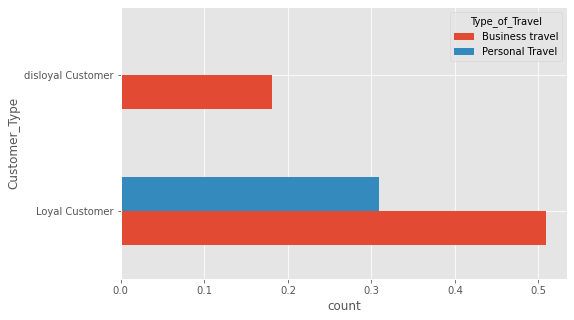

In [49]:
grouped.plot(kind='barh', figsize=(8, 5));
plt.xlabel('count');

Let' now group them with satisfaction variable

In [50]:
grouped_sat = pd.crosstab(df_train.Customer_Type, [df_train.Type_of_Travel, df_train.satisfaction], normalize=True)
grouped_sat

Type_of_Travel            Business travel                   Personal Travel  \
satisfaction      neutral or dissatisfied satisfied neutral or dissatisfied   
Customer_Type                                                                 
Loyal Customer                   0.149825  0.358853                0.277313   
disloyal Customer                0.138135  0.043043                0.001332   

Type_of_Travel               
satisfaction      satisfied  
Customer_Type                
Loyal Customer     0.031257  
disloyal Customer  0.000241

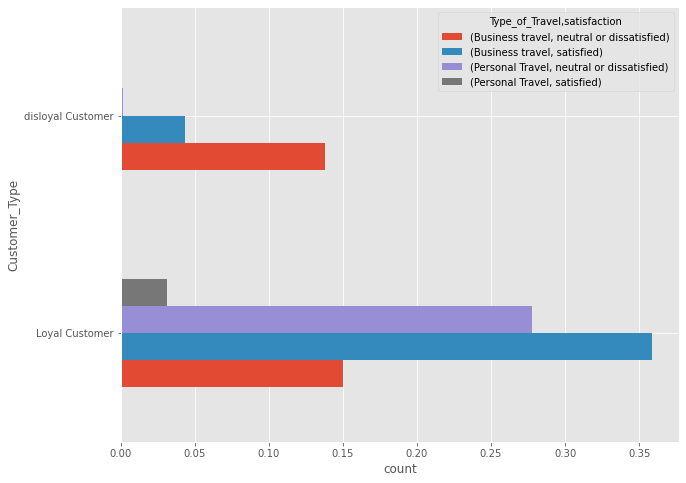

In [51]:
grouped_sat.plot(kind='barh', figsize=(10, 8));
plt.xlabel('count');

Loyal Customers in Business travel that are satisfied are the most numerous cluster, we then have dissatisfied Loyal Customer in Personal Travel.

### Levels of Satisfaction for Ordinal Features

To visualize the relations between the target and the ordinal features we make a function that estrapolate the frequency of each vote respect to the labels of the target: sattisfied and neutral or dissatisfied, then plot 

In [52]:
def percentage_chart(df_train, feature, palette=['tab:blue', 'tab:orange'], kind='bar'):
    '''
    Through a crosstab function, calculates the frequency of each label of a predictor with respect to each
    label of the target then plots the data with a bar graph or a line graph
    '''
    xx = pd.crosstab(df_train[feature], df_train['satisfaction']).reset_index() # pivot table 
    xx = xx.set_index(feature) # set index 
    xx = xx.apply(lambda x:x/x.sum()*100, axis=1).reset_index() # getting frequency % 
    xx = pd.melt(xx, id_vars=feature, var_name='satisfaction') # unpivoting dataframe to long format
    
    # barplot
    if kind=='bar': 
        sns.barplot(data=xx, x=feature, y='value', hue='satisfaction', palette=palette).set(
                ylabel='percenage of the total%', xlabel=' ')
    
    # lineplot
    elif kind=='line':
        sns.lineplot(data=xx, x=feature, y='value', hue='satisfaction', palette=palette).set(
                ylabel='percenage of the total%', xlabel=' ')
        plt.locator_params(axis='x', nbins=5)
        
    else:
        raise ValueError

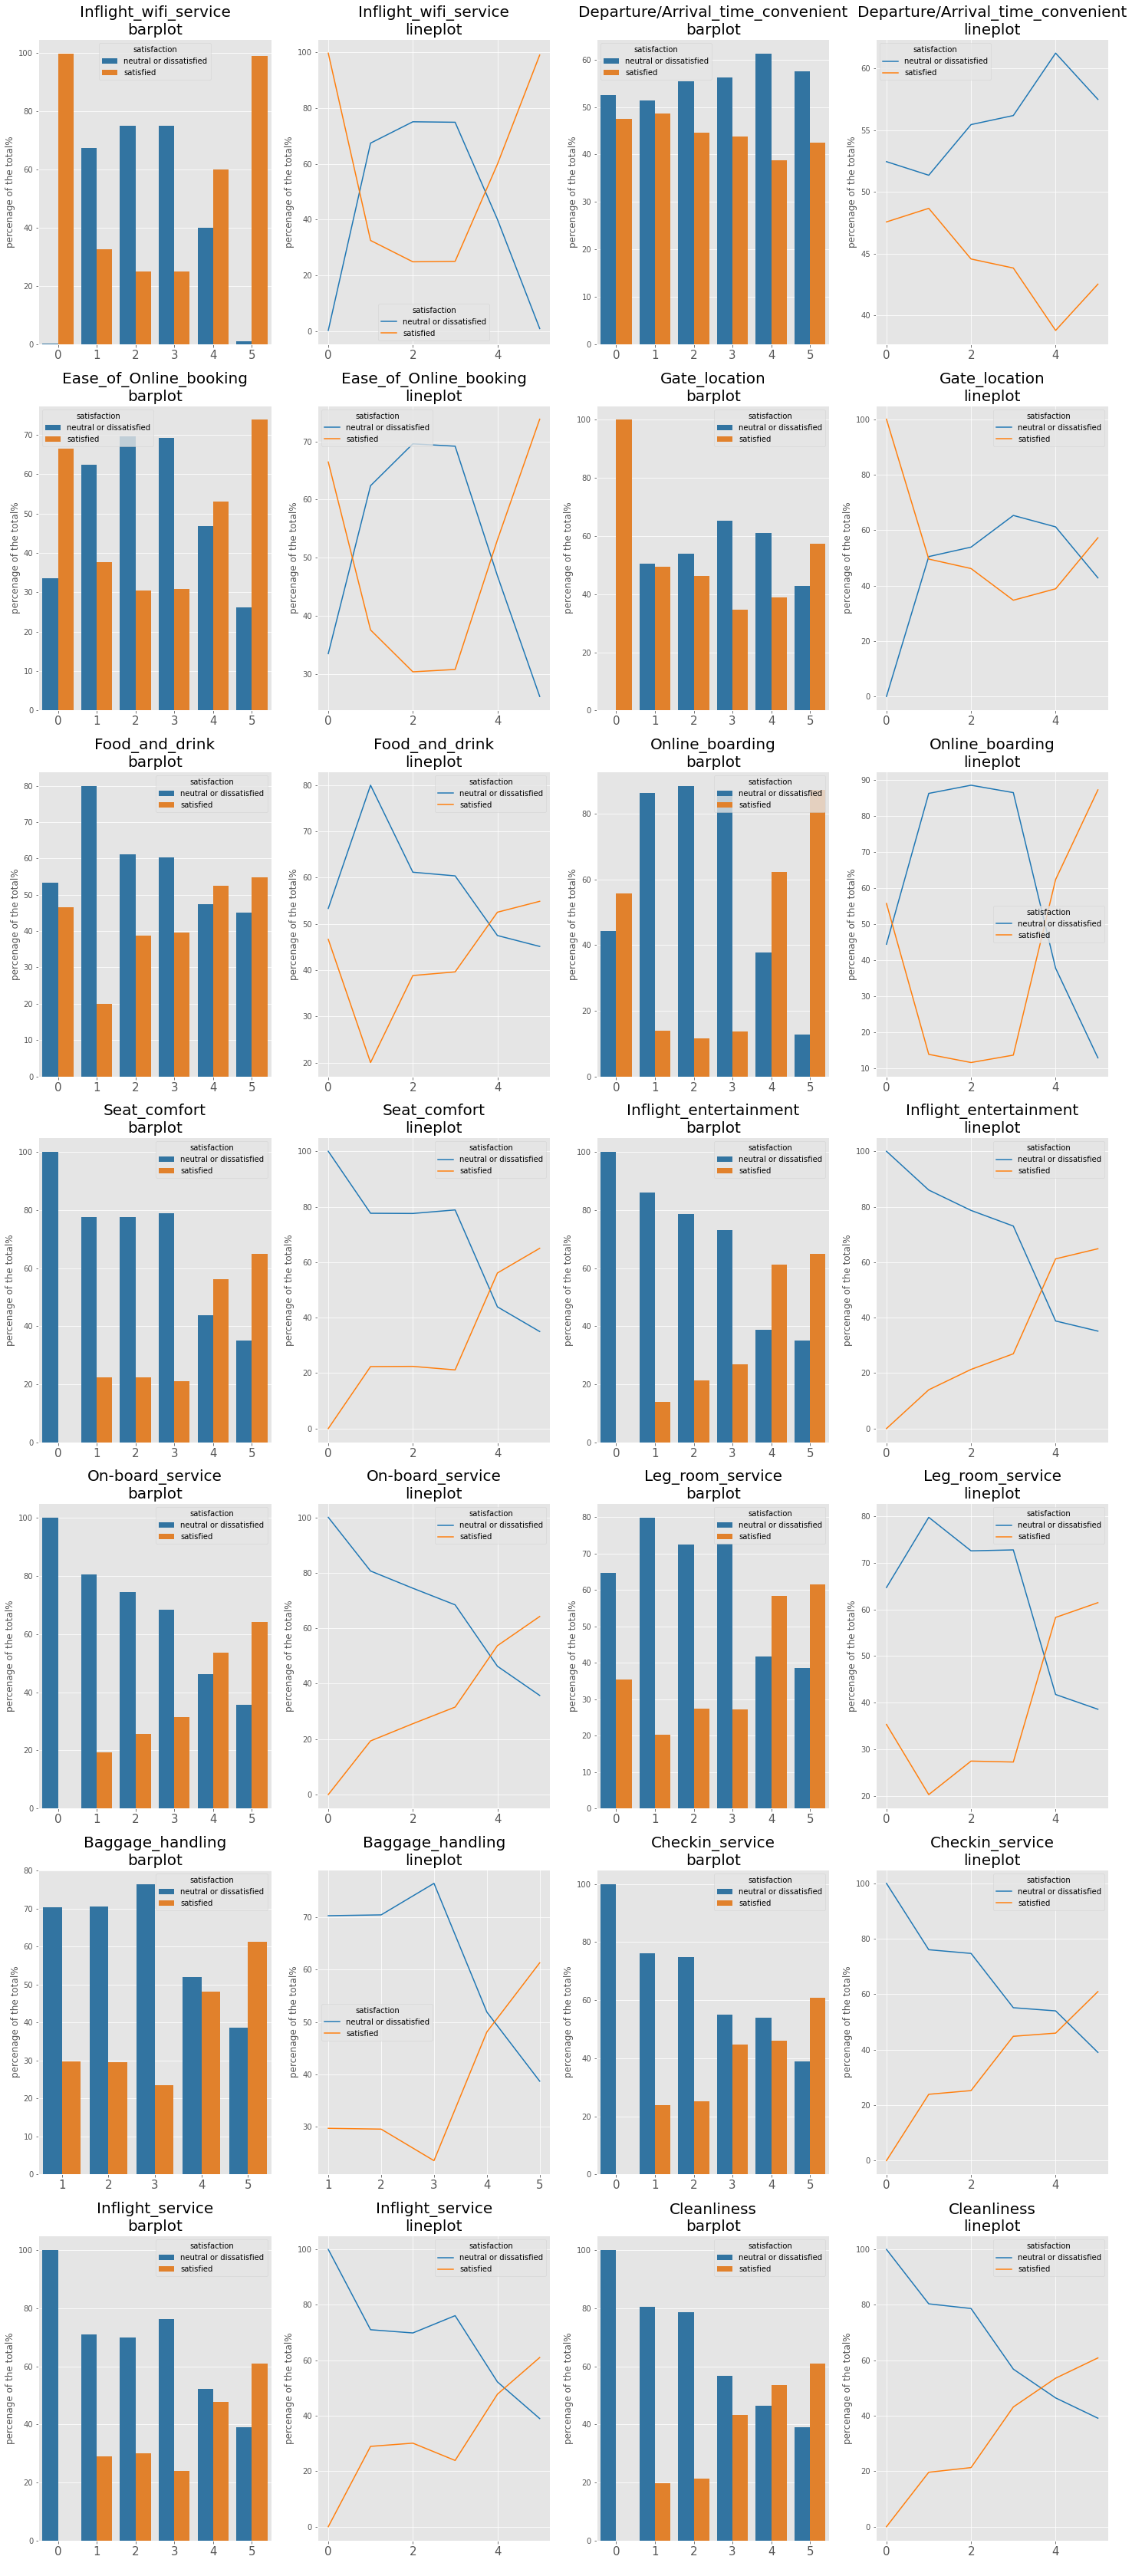

In [53]:
# setting subplot axes
a = 7  # number of rows
b = 4  # number of columns
c = 1  # initialize plot counter
d = 2

fig = plt.figure(figsize=(25, 60))

#  ploting Ordinal Data 
for feat in ordinal_feat_df.columns:
    plt.subplot(a, b, c)
    plt.title(f'{feat}\nbarplot', fontsize=20)
    plt.xticks(fontsize=15)
    percentage_chart(df_train, feat)
    c += 2
    
    plt.subplot(a, b, d)
    plt.title(f'{feat}\nlineplot', fontsize=20)
    plt.xticks(fontsize=15)
    percentage_chart(df_train, feat, kind="line")
    d += 2
    
plt.show()

For 'Departure / Arrival time convenient' and 'Gate location' the level of satisfaction is always lower than that of dissatisfaction.
While for the other variables, as the grade increases, satisfaction increases and dissatisfaction decreases.

There are some variables for which when the grades are high the frequency of satisfaction responses is more marked, for example for 'Seat_confort', 'Inflight_entertainment', 'On-boarding_service', 'Online_boarding' and 'Inflight_wifi_service', in particular people can be satisfied in case there was no service, while in case there was any they get un-satisfied when it get worse.

### Most impacting services in satisfaction

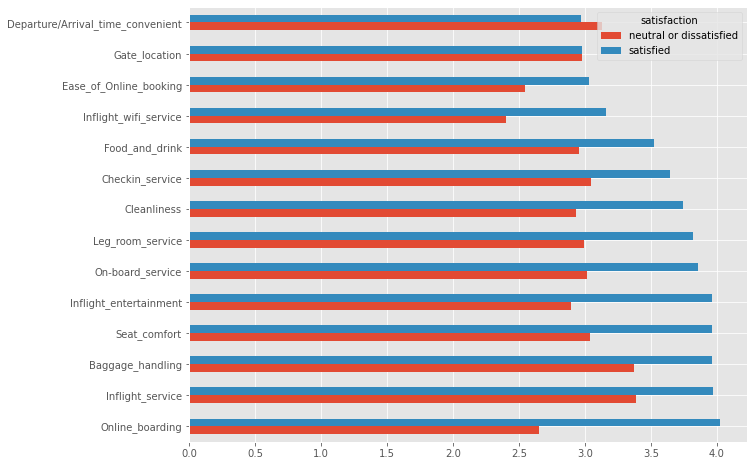

In [54]:
df_train.iloc[:, ordinal_indexes+[22]].groupby('satisfaction').mean().T.sort_values('satisfied',
                                                                       ascending=False).plot(kind='barh', figsize=(10, 8));

We can see that the service that are most evaluated in term of satisfaction are:
* Online boarding
* Inflight service
* Bagagge handling
* Seat comfort
* Inflight entertainment
* On board service
* Cleanliness

while the less considered by customers are:
* Departure/Arrival time convenient
* Gate location

### Rates of Services for Business Travels and Personal Travels

Now we will look at the most interesting features from above, i.e. **'Seat confort', 'Inflight entertainment', 'On-boarding service', 'Online boarding' and 'Inflight_wifi_service'**, respect to the satisfaction and the type of travel

We are going to define three functions that will help us in the analysis:
* **get_satisfaction_rate()** will group data from business_travels and personal_travels according to the feature of interest and the target variable *satisfaction* then count the number of observations being satisfied or dissatisfied for every unique value of the feature of interest. 
* **print_dist()** will plots the countplot of a variable by separating the observations between satisfied or dissatisfied for each unique value and for business travel and personal travel. 
* **print_plot()** will plot a stacked bar for dissatisfied and satisfied labels that highlight the observation count for each vote cast distinguishing personal travels from business travels.

In [55]:
# get the data of business travels on a separate container
b = business_travels = df_train[df_train['Type_of_Travel'] == 'Business travel']

# drop unnecessary columns
business_travels.drop(['Gender', 'Arrival_Delay_in_Minutes', 'Flight_Distance'], axis = 1, inplace = True)

In [56]:
# get the data of personal travels on a separate container
p = personal_travels = df_train[df_train['Type_of_Travel'] == 'Personal Travel']

# drop unnecessary columns
personal_travels.drop(['Gender', 'Arrival_Delay_in_Minutes', 'Flight_Distance'], axis = 1, inplace = True)

In [57]:
def get_satisfaction_rate(column):
    
    '''
    Group the data from business_travels and personal_travels according to the features of interst and 
    the target variable satisfaction then count the number of observations being satisfied or dissatisfied
    for every unique value of the feature of interest. Eventually if nan values emerge after  grouping data 
    they will be replaced with a 0 through the .fillna(0) method.
    :return: buis, pers dataframes
    '''
    # make df from count observations grouping column of interest and satisfaction
    buis =  business_travels.groupby([column, 'satisfaction'])['satisfaction'].count().unstack().fillna(0)
    pers = personal_travels.groupby([column, 'satisfaction'])['satisfaction'].count().unstack().fillna(0)
    
    return buis, pers


In [58]:
def print_dist(column):
    
    '''
    Plots the distribution of a variable by separating the observations between satisfied or dissatisfied 
    for each unique value.
    '''
    
    plt.figure(figsize = (20, 8)) # set figure size
    
    # first plot for business_travel dataset
    plt.subplot(1, 2, 1) 
    sns.countplot(x=business_travels[column], hue = 'satisfaction', #count plot column of interest in business dataset
                  data = business_travels).set_title(f'satisfaction with {column}, business travel', fontsize=17)
    plt.legend([], [], frameon=False) # remove redundant legend for this subplot

    # second plot for personal_travel dataset
    plt.subplot(1, 2, 2)
    sns.countplot(x=personal_travels[column], hue = 'satisfaction', #count plot column of interest in personal dataset 
                  data = personal_travels).set_title(f'satisfaction with {column}, personal travel', fontsize=17)

    # set legend property
    legend = plt.legend(bbox_to_anchor=(1., 1.), frameon=1, borderaxespad=0, title='satisfied')
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('white')


    plt.tight_layout()
    plt.show()
    

In [59]:
def print_plot(column):

    '''
    Draw a stacked bar for dissatisfied and satisfied labels that highlight the observation 
    count for each vote cast.
    '''
    # business travel dataset
    satis=b["satisfaction"] # select satisfaction column from business_travels dataset
    num0=satis[b[column]==0].value_counts() # satisfaction's label where response equal 0 on column of interest
    num1=satis[b[column]==1].value_counts() # satisfaction's label where response equal 1 on column of interest
    num2=satis[b[column]==2].value_counts() # satisfaction's label where response equal 2 on column of interest
    num3=satis[b[column]==3].value_counts()
    num4=satis[b[column]==4].value_counts()
    num5=satis[b[column]==5].value_counts()
    
    plotdata=pd.DataFrame({"0":num0, "1":num1, "2":num2,"3":num3,"4":num4,"5":num5}) #columns=response-rows=sat count
    plotdata2=plotdata.div(plotdata.sum(axis=1),axis=0)*100 #rows=percent of answer respect of the total of the row
    
    # plot for business travel
    plotdata2.plot(kind='barh', stacked=True, title=f'Effect of {column} on satisfaction in business travel')
    
    
    # set the legend outside the box
    legend = plt.legend(bbox_to_anchor=(1., 0.7), frameon=1, borderaxespad=0) 
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('white')

    # personal travel dataset
    satis=p["satisfaction"] # select satisfaction column from personal_travels dataset
    num0=satis[p[column]==0].value_counts() # satisfaction's label where response equal 0 on column of interest
    num1=satis[p[column]==1].value_counts()
    num2=satis[p[column]==2].value_counts()
    num3=satis[p[column]==3].value_counts()
    num4=satis[p[column]==4].value_counts()
    num5=satis[p[column]==5].value_counts()
    plotdata=pd.DataFrame({"0":num0, "1":num1, "2":num2,"3":num3,"4":num4,"5":num5}) #columns==response-rows==sat count
    plotdata2=plotdata.div(plotdata.sum(axis=1),axis=0)*100 #rows==percent of answer respect of the total of the row
    
    # plot for personal travel 
    plotdata2.plot(kind='barh', stacked=True, title=f'Effect of {column} on satisfaction in personal travel')
    
    # set the legend outside the box
    legend = plt.legend(bbox_to_anchor=(1., 0.7), frameon=1, borderaxespad=0)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('white')


### Inflight wifi service and satisfaction

In [60]:
# Grouping business and personal travel datasets by Inflight wifi service and satisfaction.
wifi_sat_business, wifi_sat_personal = get_satisfaction_rate('Inflight_wifi_service')

display(wifi_sat_business, wifi_sat_personal)

satisfaction,neutral or dissatisfied,satisfied
Inflight_wifi_service,,
0,8,2441
1,6215,5786
2,9804,6409
3,9559,6462
4,4139,10501
5,106,10035


satisfaction,neutral or dissatisfied,satisfied
Inflight_wifi_service,,
0,0.0,647.0
1,5780.0,0.0
2,9542.0,0.0
3,9768.0,0.0
4,3776.0,1321.0
5,0.0,1295.0


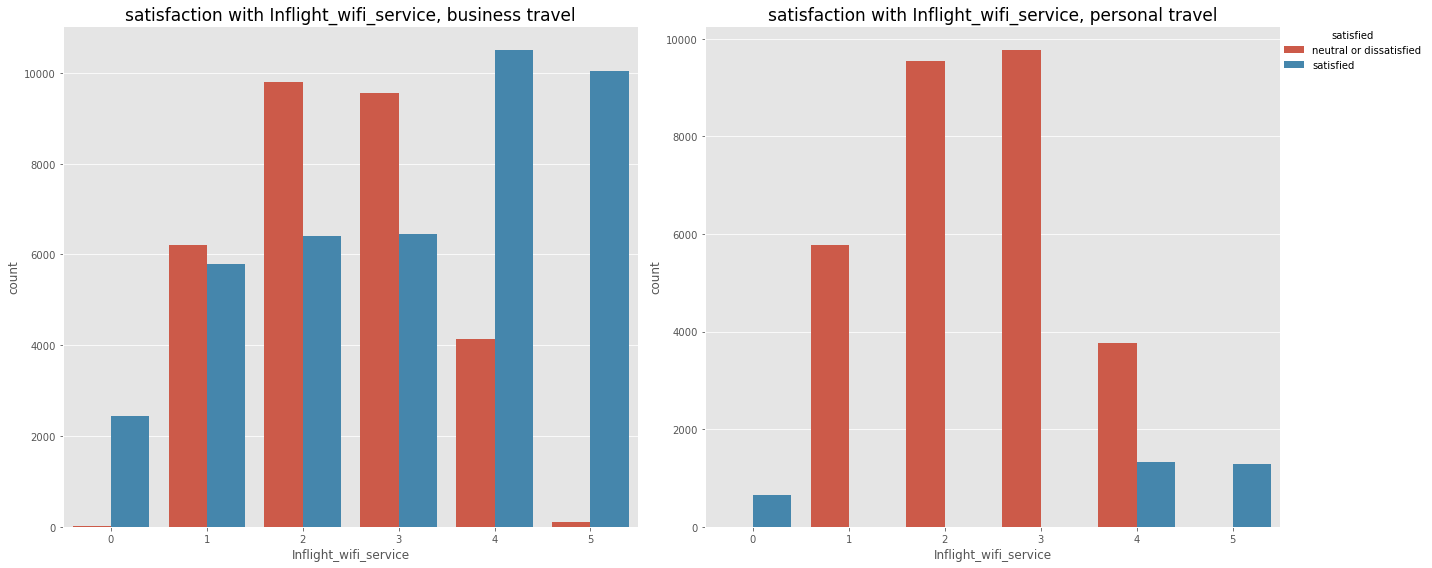

In [61]:
print_dist('Inflight_wifi_service') # print distribution of Inflight_wifi_service

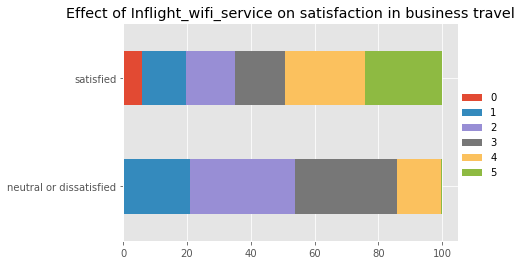

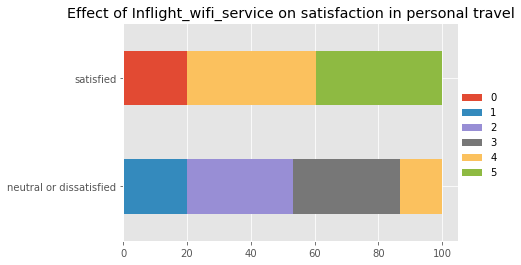

In [62]:
print_plot('Inflight_wifi_service') # distribution of votes of the service according to target labels.

### Online boarding and Satisfaction

In [63]:
onlineboard_sat_buisness, onlineboard_sat_personal = get_satisfaction_rate('Online_boarding')

display(onlineboard_sat_buisness, onlineboard_sat_personal)

satisfaction,neutral or dissatisfied,satisfied
Online_boarding,,
0,227,865
1,4734,1375
2,8186,1889
3,10588,2729
4,5857,17892
5,239,16884


satisfaction,neutral or dissatisfied,satisfied
Online_boarding,,
0,846,482
1,4453,96
2,7251,123
3,8202,225
4,5705,1217
5,2409,1120


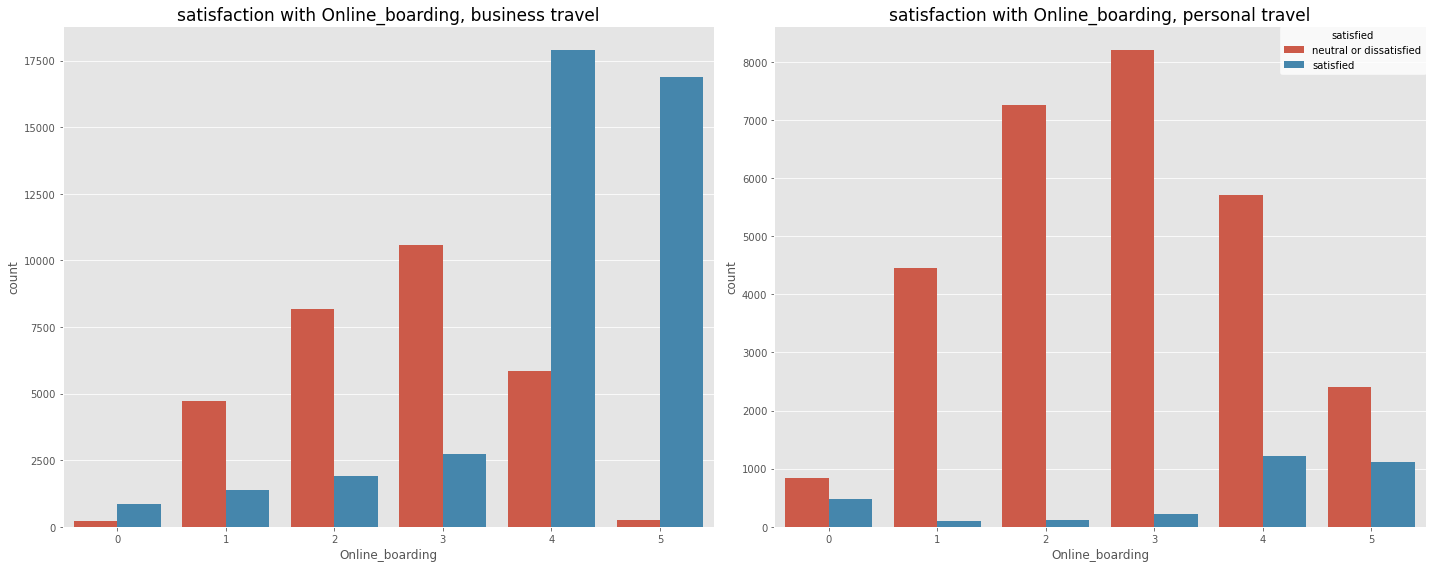

In [64]:
print_dist('Online_boarding')

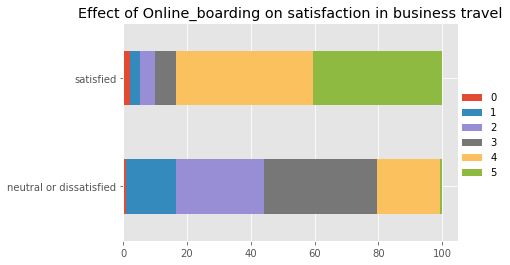

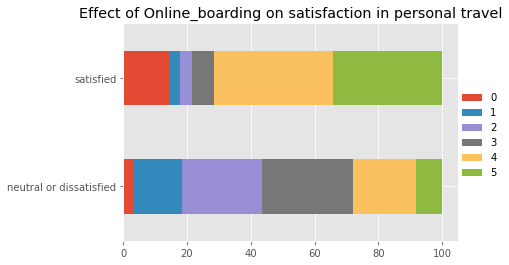

In [65]:
print_plot('Online_boarding')

### Seat comfort and Satisfaction

In [66]:
seatcomf_sat_buisness, seatcomf_sat_personal = get_satisfaction_rate('Seat_comfort')

display(seatcomf_sat_buisness, seatcomf_sat_personal)

satisfaction,neutral or dissatisfied,satisfied
Seat_comfort,,
0,1.0,0.0
1,4722.0,2174.0
2,6507.0,2753.0
3,8982.0,3352.0
4,6717.0,16912.0
5,2902.0,16443.0


satisfaction,neutral or dissatisfied,satisfied
Seat_comfort,,
1,4619,516
2,5009,577
3,5715,592
4,7190,863
5,6333,715


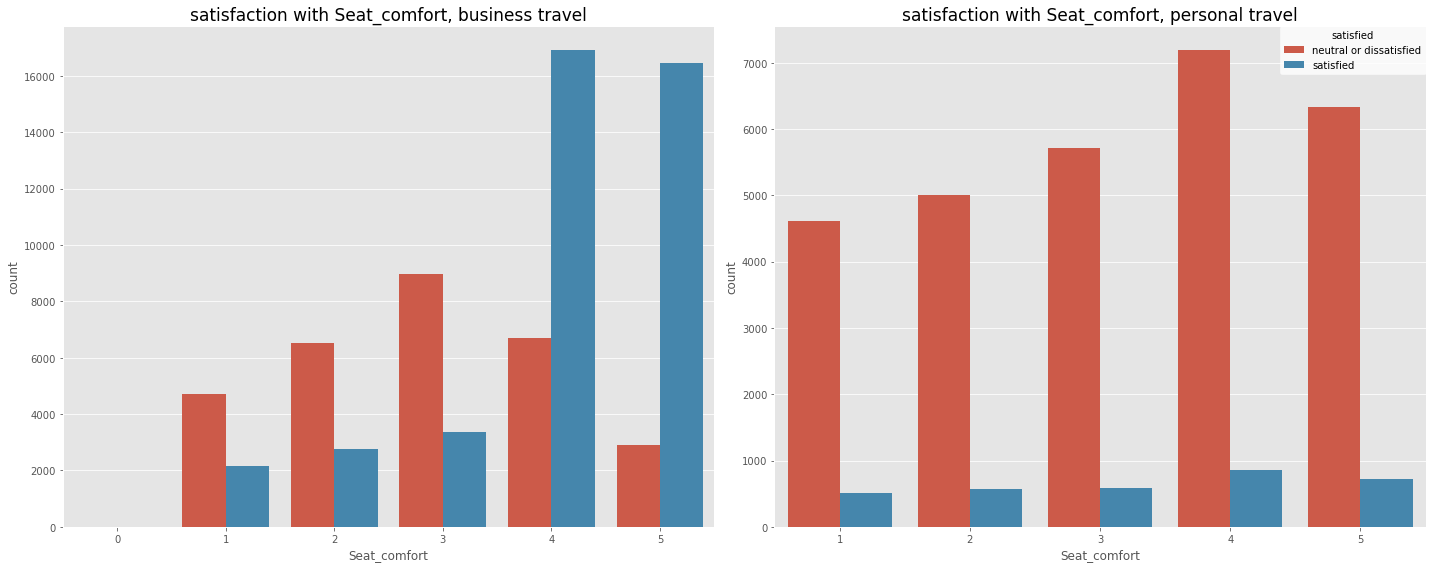

In [67]:
print_dist('Seat_comfort')

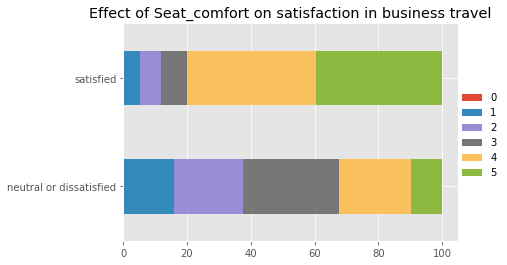

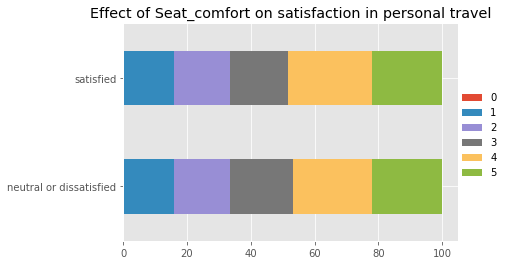

In [68]:
print_plot('Seat_comfort')

### Inflight entertainment and Satisfaction

In [69]:
infl_ent_sat_buisness, infl_ent_sat_personal = get_satisfaction_rate('Inflight_entertainment')

display(infl_ent_sat_buisness, infl_ent_sat_personal)

satisfaction,neutral or dissatisfied,satisfied
Inflight_entertainment,,
0,14.0,0.0
1,5732.0,1154.0
2,7922.0,3080.0
3,7848.0,4474.0
4,5335.0,17270.0
5,2980.0,15656.0


satisfaction,neutral or dissatisfied,satisfied
Inflight_entertainment,,
1,4969,586
2,5907,670
3,6086,672
4,6046,684
5,5858,651


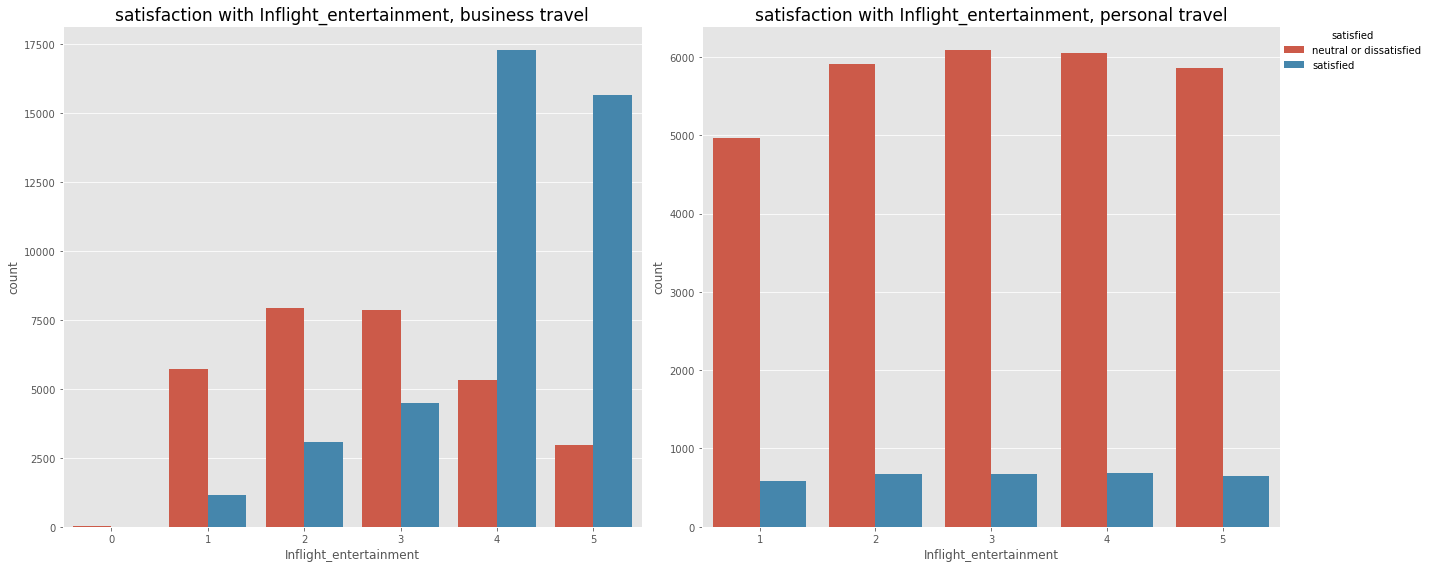

In [70]:
print_dist('Inflight_entertainment')

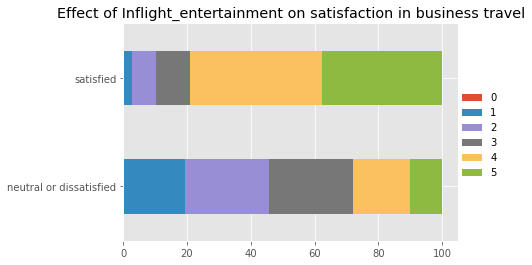

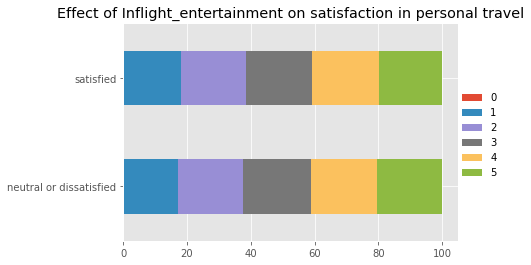

In [71]:
print_plot('Inflight_entertainment')

### On board service and Satisfaction

In [72]:
board_serv_sat_buisness, board_serv_sat_personal = get_satisfaction_rate('On-board_service')

display(board_serv_sat_buisness, board_serv_sat_personal)

satisfaction,neutral or dissatisfied,satisfied
On-board_service,,
0,3.0,0.0
1,5775.0,1844.0
2,6831.0,3307.0
3,8049.0,6327.0
4,6782.0,15662.0
5,2391.0,14494.0


satisfaction,neutral or dissatisfied,satisfied
On-board_service,,
1,3766,447
2,4059,435
3,7534,860
4,7464,865
5,6043,656


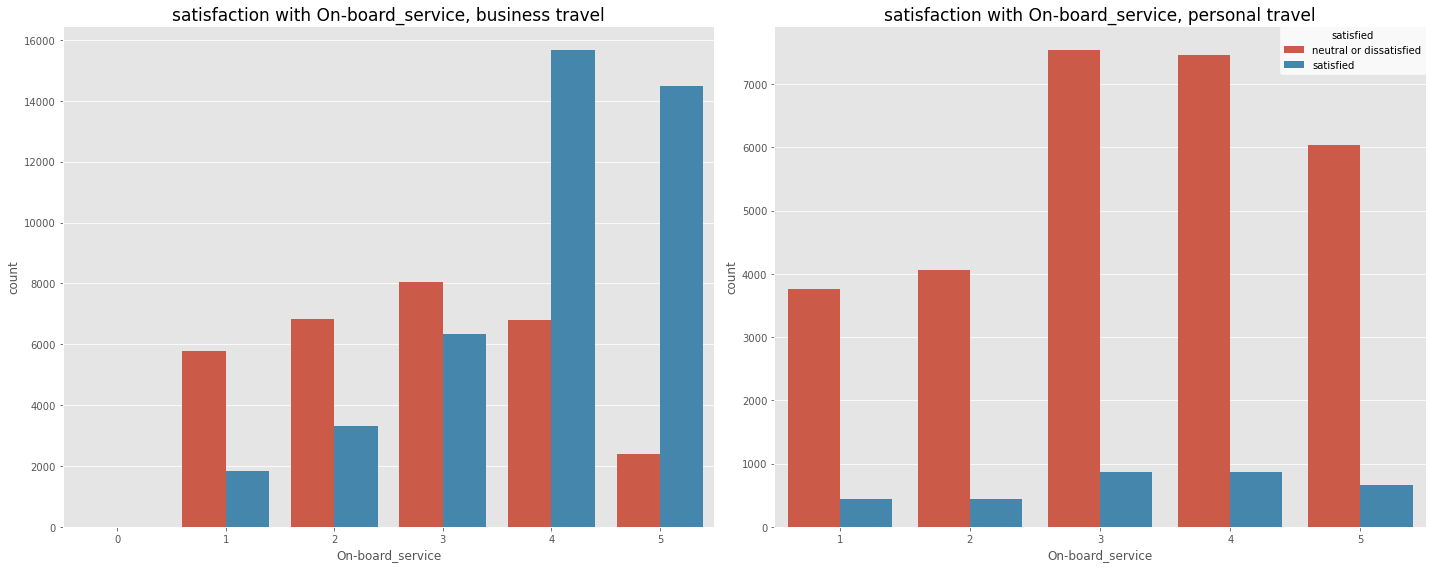

In [73]:
print_dist('On-board_service')

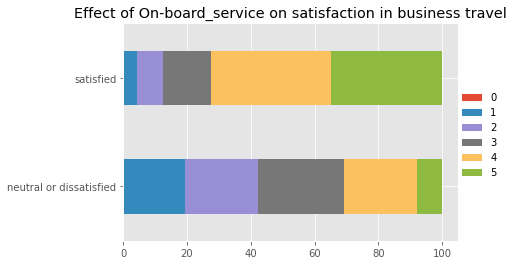

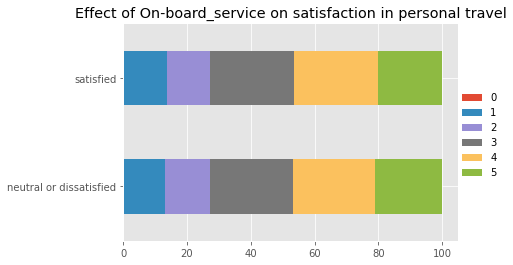

In [74]:
print_plot('On-board_service')

From the above plots we can make similar consideration for all the examined services:

For business travellers, people can be satisfied in case the service is consider of high level; they get un-satisfied when it get worse.
We can conclud then that services are affecting feautres.

In case of personal travellers, despite the fact that they were always unsattisfied we find that it's the same case: when passengers get a bad service they become significantlly dissatisfied, so to increase people satisfaction we can improve service.

<a id="2.6"></a>
## 2.6 Exploratory Data Analysis Conclusion

Onboard Service is the most important flight service attribute and Online Boarding is the most important pre-flight service attribute for passengers.

Departure/Arrival Time Convenience and Gate location are considered a less important attribute by passengers.

The most satisfied group of customers are mostly business passenger's traveling in the business class. On the other hand, the satisfaction can be significantly improved in a large group of business customers traveling in eco class.

The flight entertainment has very strong positive impact on passenger's satisfaction.

If the airline wants to improve satisfaction of selected segments of customers, then personal travel should be number 1 priority.

<a id="3"></a>
# 3. Data Preprocessing
[Back to Table of Content](#0)

<a id="3.1"></a>
## 3.1 Encoding Categorical Variable

The process of turning categorical data into usable, machine-learning ready, numerical data is called categorical encoding.
There are different methods for encoding variables which mostlly depend on the nature of the variable that is being transformed. Categorical variables could be nominal or ordinal; nominal refer to variable where the label are just names like personal names or animal names; ordinal refers to variable where the labels has an intrinsic order, like first, second and therd place or high, medium and low. 

We will try the below encoding approaches and evaluate which is better.

* **Ordinal** — convert string labels to integer values 1 through k.
* **OneHot** — one column for each value to compare vs. all other values.
* **Backward Difference** — the mean of the dependent variable for a level is compared with the mean of the dependent variable for the prior level. Usefull for nominal or ordinal variable.


The workflow will develop in 7 main steps:
1. Make a copy of the data
2. Label encode the target variable
3. Separate the independent variables from the dependent variable for encoding evaluation method
4. Test through cross validation different encoding methods
5. Evaluate the results and decide which encoding method to use
6. Encode the data

In [75]:
# make a copy of the train set
df_train1 = df_train.copy()
df_train1.head(2)

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied


Same for test set

In [76]:
# make a copy of the test set
df_test1 = df_test.copy()
df_test1.head(2)

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,satisfied


The target variable *satisfaction* is categorical of binary type, we will encode it as 0 for 'neutral or dissatisfied' and 1 for 'satisfied'.

In [77]:
# encoding target variable
df_train1['satisfaction'] = df_train1['satisfaction'].map({'neutral or dissatisfied':0, 'satisfied':1})
df_test1['satisfaction'] = df_test1['satisfaction'].map({'neutral or dissatisfied':0, 'satisfied':1})

Separate the predictors from the target

In [78]:
# separate input and output variable
X1, y1 = df_train1.drop('satisfaction', axis=1), df_train1['satisfaction']
X1.shape, y1.shape

((103594, 22), (103594,))

For testing different encoding methods we will use the category_encoders library, that allow as to easily implement various encoding tecnique within a sklearn pipeline.

Steps:
1. encoder_list: list of different encodig tecnique;
2. For loop iterating the list of step 1.
    * 2.1 pipeline step for normalizing numerical features
    * 2.2 pipeline step for encoding categorical features
    * 2.3 ColumnTransformer object to combine the transformation of the numerical and categorical features
    * 2.4 pipeline object with two steps: first preprocess data as stated in the columntransformer object; second apply the machine learning model. As model we opted for a RandomForestClassifier;
    * 2.5 stratifying data with StratifiedKFold, a variation of k-fold cross validation, that returns stratified splits, i.e creates splits by preserving the same percentage for each target class as in the complete set. We do not really need a stratified k-fold cross validation given our set is balance but for binary classification problems is recommended. We split the data in 10 folds with 20% of each as validation set.    
    * 2.6 print the name of the encoder
    * 2.7 print the mean of the 10 fold cross validation results for each method. 

In [79]:
encoder_list = [ce.backward_difference.BackwardDifferenceEncoder,
                ce.one_hot.OneHotEncoder,
                ce.ordinal.OrdinalEncoder
                ]


for encoder in encoder_list:
    numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])
    categorical_transformer = Pipeline(steps=[('woe', encoder())])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
    
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(random_state=42))])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    print(encoder)
    print(cross_val_score(pipe, X1, y1, cv=cv, n_jobs=-1).mean())

<class 'category_encoders.backward_difference.BackwardDifferenceEncoder'>
0.9612429412266998
<class 'category_encoders.one_hot.OneHotEncoder'>
0.9623433897555296
<class 'category_encoders.ordinal.OrdinalEncoder'>
0.9612236366734068


We will use OneHotEncoder method to encode categorical features.

We first create a copy of the dataset, then proceed to encode the variables by the pandas function get_dummies that automatically perform the encoding task assigning a new column to each label of the variable and drop it.

In [80]:
# Copy of the dataset
train_encoded = df_train1.copy()
test_encoded = df_test1.copy()

In [81]:
# One hot encoding train categorical varible
train_encoded = pd.get_dummies(train_encoded, columns=categorical_features)
train_encoded.head(2)

,Age,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,...,satisfaction,Gender_Female,Gender_Male,Customer_Type_Loyal Customer,Customer_Type_disloyal Customer,Type_of_Travel_Business travel,Type_of_Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
0,13,460,3,4,3,1,5,3,5,5,...,0,0,1,1,0,0,1,0,0,1
1,25,235,3,2,3,3,1,3,1,1,...,0,0,1,0,1,1,0,1,0,0


In [82]:
# One hot encoding test categorical varible
test_encoded = pd.get_dummies(test_encoded, columns=categorical_features)
test_encoded.head(2)

,Age,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,...,satisfaction,Gender_Female,Gender_Male,Customer_Type_Loyal Customer,Customer_Type_disloyal Customer,Type_of_Travel_Business travel,Type_of_Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
0,52,160,5,4,3,4,3,4,3,5,...,1,1,0,1,0,1,0,0,1,0
1,36,2863,1,1,3,1,5,4,5,4,...,1,1,0,1,0,1,0,1,0,0


### Split of the independent variables from dependent variable

In [83]:
# separate input and output variable - train set
X_train, y_train = train_encoded.drop('satisfaction', axis=1).copy(), train_encoded['satisfaction'].copy()
X_train.shape, y_train.shape

((103594, 27), (103594,))

In [84]:
# separate input and output variable - test set
X_test, y_test = test_encoded.drop('satisfaction', axis=1).copy(), test_encoded['satisfaction'].copy()
X_test.shape, y_test.shape

((25893, 27), (25893,))

<a id="3.2"></a>
## 3.2 Scaling the Data

Many machine learning algorithms work best when numeric input variables are scaled to a standard range.

This includes algorithms that use a weighted sum of the input, such as linear regression, and algorithms that use distance measurements, such as k-Nearest Neighbors.

The two most popular techniques for scaling numerical data before modeling are normalization and standardization. Normalization scales each input variable separately to the range 0-1. Standardization scales each input variable separately by subtracting the mean (called centering) and dividing by the standard deviation to shift the distribution to have a mean of zero and a standard deviation of one.

To select the best scaling procedure for our data, I tested several models separately and found that the performance was quite similar; assuming that the data is not normally distributed, and the fact that normalization is in principle more suitable than standardization in these cases, I decided on the former.

In [85]:
# train set
scaler = MinMaxScaler() # create an istance of normalization scaling class
scaler.fit(X_train) # fit the scaler to train data - the algo find min-max values for all the column

# scale the data with tranform method - apply the formula (data-np.min(col))/(np.max(col)-np.min(col)) to all the column
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns) 

X_train.shape

(103594, 27)

In [86]:
# test set

# scale the data with tranform method - apply the formula (data-np.min(col))/(np.max(col)-np.min(col)) to all the column
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns) 

X_test.shape

(25893, 27)

<a id="3.3"></a>
## 3.3 Preprocessed Dataframe

New dataframe with the preprocessed data for future use

In [87]:
y_train = y_train.reset_index(drop=True) # reset y_train index and drop old one
X_train.index.equals(y_train.index) # verify if X_train and y_train has same index

True

In [88]:
prep_df = pd.concat([X_train, y_train], axis=1) # assign new dataframe to variable prep_df
prep_df.head(2)

,Age,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,...,Gender_Female,Gender_Male,Customer_Type_Loyal Customer,Customer_Type_disloyal Customer,Type_of_Travel_Business travel,Type_of_Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus,satisfaction
0,0.076923,0.086632,0.6,0.8,0.6,0.2,1.0,0.6,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0
1,0.230769,0.041195,0.6,0.4,0.6,0.6,0.2,0.6,0.2,0.2,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0


In [89]:
prep_df.isnull().sum().sum() # verify null values

0

<a id="4"></a>
# 4. Correlation with Target and Features Selection
[Back to Table of Content](#0)

We want to find out which features are most decisive in the behavior of the target.

We will perform features selection to select the 4 most informative features and save them in a separate traning set, by performing:

* **Chi-square Test** for Feature Extraction:\
    Chi-square test is a non-parametric statistic test, best used in case predictor and outcome are categorical. 
    The basic idea behind the test is to compare the observed values between two groups of data to the expected values that would have been seen if the null hypothesis of indipendence between the groups were true.

* **ANOVA Test** \
    Analysis Of Variance is a parametric comparison test, best used for categorical predictor variables and quantitative output variable, as for numerical predictors and categorical output. ANOVA is an extension of the t-test used to compare two or more groups at the same time, it consists of a set of statistical techniques that compare the variability within these groups with the variability of the target.
    
* **Mutual Information Features Selection** \
    Mutual Information is a non-parametric test that can detect non-linear relationships. Mutual information is straightforward when considering the distribution of two discrete (categorical or ordinal) variables, such as categorical input and categorical output data. Nevertheless, it can be adapted for use with numerical input and categorical output.
    It measures the amount of information one can obtain from one random variable given another. In other words, how much
    will the target variable be impacted if we remove or add the feature. MI is 0 if both the variables are independent and
    ranges between 0 – 1 if the predictor variable is deterministic of Y.

<a id="4.1"></a>
## 4.1 Correlation through Chi-Square

For the chi-square test we will use the scipy.stats library since the scikit-learn chi2 class is designed to work with binary features and this is not always the case and its implementation can lead to misleading results.
See the issue # 21455 at https://github.com/scikit-learn/scikit-learn/issues/21455, on the topic.

Steps to perform chi2 test:
1. iterate through prep_df categorical columns
2. make a subset with the i-th column and the target
3. make contingecy table of the 2 features
4. calculate chi2 score and p_value for each predictor
5. make dataframe for scores and p_value
5. print best 4 features and plot the results

Top 4 informative features for chi2 test:
                              Score  P_Values
Online_boarding        39619.242059       0.0
Inflight_wifi_service  28607.042429       0.0
Class_Business         26306.618894       0.0
Class_Eco              21086.010318       0.0


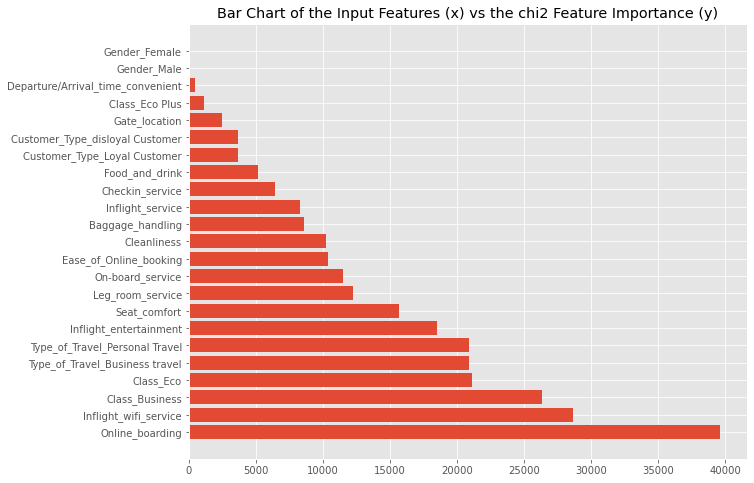

In [90]:
df_scores = []
df_pvalue = []
columns = prep_df.columns.drop(list(num_col) + ['satisfaction']) 

for i in columns:    
    # Select predictor variable
    df_predictor = prep_df[i]
    # Select dependent variable
    df_target = prep_df['satisfaction']
    
    df_chi2 = pd.DataFrame({i:df_predictor, 
                           "satisfaction":df_target})

    # contingency table - contains the observed frequencies
    df_observed = pd.crosstab(df_chi2[i], df_chi2.satisfaction)

    # calculate the chi2 scores for each variable and append the score to the list df_score
    # and the p-value to the list df_pvalue
    df_scores.append(stats.chi2_contingency(observed= df_observed)[0])
    df_pvalue.append(stats.chi2_contingency(observed= df_observed)[1])
    
# dataframe with predictor names as index and scores and p_values as columns, sorted by Score 
chi2_scores = pd.DataFrame({'Score':df_scores,
                              'P_Values':df_pvalue}, index=columns).sort_values('Score', ascending=False)

# print top features
print('Top 4 informative features for chi2 test:')
print(chi2_scores.head(4))

# orizontal barplot for visualizing chi2 results for each column
plt.figure(figsize=(10, 8))
plt.barh([chi2_scores.index[i] for i in range(len(chi2_scores))], chi2_scores['Score'])
plt.title('Bar Chart of the Input Features (x) vs the chi2 Feature Importance (y)')
plt.show()

We can see that all the features are related to the target, i.e. the p-value is very low for all of them so we can always reject the null hipothesys of independence, but the chi2 score differs highly between each other.

We now proceed checking feature importance with ANOVA and Mutual Importance test.

<a id="4.2"></a>
## 4.2 Correlation through ANOVA

SelectKBest class is a Scikit-learn feature_selection routine object; it perform univariate feature selection by selecting the best features based on univariate statistical tests. It has two parameters:
* score_func: 
    - Function taking two arrays X and y, and returning a pair of arrays (scores, pvalues) or a single array with scores.
      Default is f_classif function that perform ANOVA test between feature for classification tasks.
* k:
    - Number of top features to select. The “all” option bypasses selection, for use in a parameter search.

Steps to perform ANOVA f-test:
1. make dataframe of only numerical features
2. assign SelectKBest object to a variable with default score_func
3. fit the object to the predictors and the target
4. make dataframe for scores and p_value
5. print best 4 features and plot the results

In [91]:
X_num = X_train[num_col] # numerical df
anova_fs = SelectKBest(k=4) # instantiating anova test
anova_fs.fit(X_num, y_train) # fit anova test

# dataframe of scores and p_values
anova_scores = pd.DataFrame({'Scores': anova_fs.scores_, 'p_values': anova_fs.pvalues_}, index=X_num.columns)
anova_scores = anova_scores.sort_values('Scores', ascending=False)

Top 4 informative features for ANOVA test: 
                                  Scores      p_values
Flight_Distance             10164.144626  0.000000e+00
Age                          1982.685800  0.000000e+00
Arrival_Delay_in_Minutes      344.619158  8.391470e-77
Departure_Delay_in_Minutes    265.019573  1.638513e-59


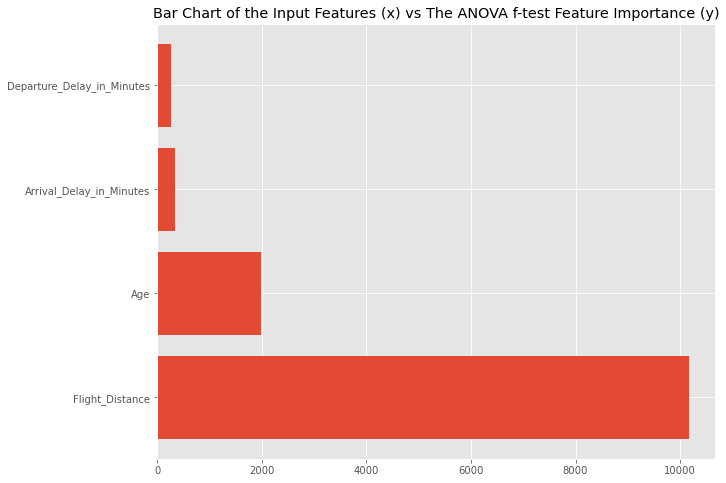

In [92]:
# print ANOVA top features
print(f'Top 4 informative features for ANOVA test: \n{anova_scores.head(4)}')

# plot results
plt.figure(figsize=(10, 8))
plt.barh([anova_scores.index[i] for i in range(len(anova_scores))], anova_scores['Scores'])
plt.title('Bar Chart of the Input Features (x) vs The ANOVA f-test Feature Importance (y)')
plt.show()

<a id="4.3"></a>
## 4.3 Correlation through Mutual Information

To perform MI test we will use SelectKBest with mutual_info_classif method as score_func on all the data. The process is then the same as for ANOVA test.

In [93]:
mi_fs = SelectKBest(score_func=mutual_info_classif)
mi_fs.fit(X_train, y_train)

# dataframe of scores and p_values
mi_scores = pd.DataFrame({'Scores': mi_fs.scores_}, index=X_train.columns)
mi_scores = mi_scores.sort_values('Scores', ascending=False)

Top 4 informative features for MI test: 
                                  Scores
Online_boarding                 0.213356
Inflight_wifi_service           0.164842
Class_Business                  0.136272
Type_of_Travel_Business travel  0.120061


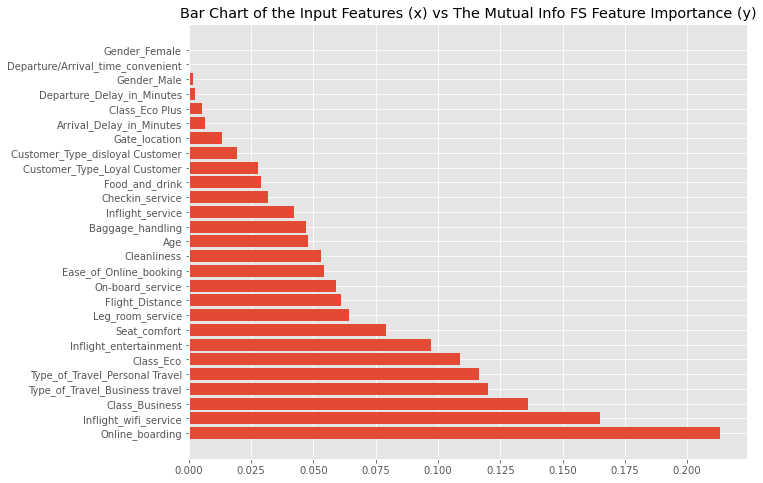

In [94]:
# print MI top features
print(f'Top 4 informative features for MI test: \n{mi_scores.head(4)}')

plt.figure(figsize=(10, 8))
plt.barh([mi_scores.index[i] for i in range(len(mi_scores))], mi_scores['Scores'])
plt.title('Bar Chart of the Input Features (x) vs The Mutual Info FS Feature Importance (y)')
plt.show()

<a id="4.4"></a>
## 4.4 Feature Selection

Comparing the 3 methods we see that the best 4 features are the following:
1. Online_boarding
2. Inflight_wifi_service
3. Class_Business
4. Type_of_Travel_Business travel

We will then create a dataframe made of only this features

In [95]:
X_fsel = X_train[['Online_boarding',
                  'Inflight_wifi_service',
                  'Class_Business',
                  'Type_of_Travel_Business travel']]
X_fsel.shape

(103594, 4)

<a id="5"></a>
# 5. Selection of the Machine Learning Models
[Back to Table of Content](#0)

To evaluate the performance of the models, as **reference metric**, we will use **Accuracy**. Our dataset is well balanced so that the accuracy (i.e. total of correct forecasts on all forecasts) turns out to be a good indicator in these cases.

In case of a not balanced dataset, I would have opted for other metric such as F1_score metric, that is the armonic mean of precision and recall metrics, or the ROC-AUC score and the ROC_curve which is a probability curve that plots the TPR (True Positive Rate) versus the FPR (False Positive Rate) at various threshold values.

In this project, we will implement 4 ensemble models:
1. Random Forest Classifier (RandomForestClassifier)
2. Ada Boost Classifier (AdaBoostClassifier)
3. Light Gradient Boosting Machine Classifier (LGBMClassifier)
4. Extrem Gradient Boosting Classifier (XGBClassifier)

We will select the best two on the basis of a spot-check, i.e. we will run each model on the data with the default settings and we will take the ones that returned the best results. On the best two models we will then perform the tuning of the hyperparameters in order to better adapt them to our dataset. Once this last phase is completed we will use the trained models on the test set to make the final prediction and choose the best one.

<a id="5.1"></a>
## 5.1 Spot check - Which Algorithms Perform Better?

Spot-checking is an automated way to objectively analyse and discover which algorithms are best at picking out the structure in the problem, so we can focus our attention on them.

We first define the following functions to train models on the data and return the cross validation accuracy scores:

1. define_model: return a dictionary containing the models instantiation;
2. make_pipeline: return a pipeline for one model
3. evaluate_model: evaluate the performance of a single model throught a cross_validation process. Arguments of the function are the training set X, y, the model which will be evaluated, folds: the number of subsamples into which the dataset will be divided, and the metric.The function first recal the make_pipeline to input the model, then the cross validation process is assign to the variable score which will be returned by the function.
4. evaluate_models: evaluate all the models that are instantiated in define_model by recalling evaluate_model. Metric is by default set as accuracy. Return the dictionary results with arguments the name of the model as keys and a list of the 10 scores as values. The function also print the name of the model with its scores and the standar deviation between them.
5. summarize_results: print the mean of the result of the models performance up to the tenth with the relative names and standard deviation, as well as the boxplot of said results.

After defined the above functions we evaluate the selected model on our dataset. 

In [96]:
# create a dict of standard models to evaluate {name:object}
def define_models(models=dict()):
    # ensemble models
    n_trees = 200 # set the number of estimators
    models['ada'] = AdaBoostClassifier(n_estimators=n_trees)
    models['rf'] = RandomForestClassifier(n_estimators=n_trees)
    models['lgb'] = LGBMClassifier(n_estimators=n_trees)
    models['xgb'] = XGBClassifier(n_estimators=n_trees)
    print('Defined %d models' % len(models))
    return models

# create a feature preparation pipeline for a model
def make_pipeline(model):
    steps = list()
    # the model
    steps.append(('model', model))
    # create pipeline
    pipeline = Pipeline(steps=steps)
    return pipeline

# evaluate a single model
def evaluate_model(X, y, model, folds, metric):
    # create the pipeline
    pipeline = make_pipeline(model)
    # evaluate model
    scores = cross_val_score(pipeline, X, y, scoring=metric, cv=folds, n_jobs=-1)
    return scores

# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, folds=10, metric='accuracy'):
    results = dict()
    for name, model in models.items():
        # evaluate the model
        scores = evaluate_model(X, y, model, folds, metric)
        # show process
        if scores is not None:
            # store a result
            results[name] = scores
            mean_score, std_score = np.mean(scores), np.std(scores)
            print(f'>{name}: {mean_score:.5f} (+/-{std_score:.5f})')
        else:
            print(f'>{name}: error')
    return results

# print and plot the top n results
def summarize_results(results, maximize=True, top_n=10):
    # check for no results
    if len(results) == 0:
        print('no results')
        return
    # determine how many results to summarize
    n = min(top_n, len(results))
    # create a list of (name, mean(scores)) tuples
    mean_scores = [(k, np.mean(v)) for k,v in results.items()]
    # sort tuples by mean score
    mean_scores = sorted(mean_scores, key=lambda x: x[1])
    # reverse for descending order (e.g. for accuracy)
    if maximize:
        mean_scores = list(reversed(mean_scores))
    # retrieve the top n for summarization
    names = [x[0] for x in mean_scores[:n]]
    scores = [results[x[0]] for x in mean_scores[:n]]
    # print the top n
    print()
    for i in range(n):
        name = names[i]
        mean_score, std_score = np.mean(results[name]), np.std(results[name])
        print(f'Rank={i+1}, Name={name}, Score={mean_score:.5f} (+/- {std_score:.5f})')
    # boxplot for the top n
    plt.boxplot(scores, labels=names)
    _, labels = plt.xticks()
    plt.setp(labels, rotation=90)

Now we will evaluate the selected machine learning algorithms on the data. We will explore 2 ways:
- **Way 1**. evaluate the models using all the predictors present in the data.
- **Way 2**. evaluate the models on X_fsel subset which contain the most informative features as selected from the features selection step.

### Way 1 - All Features

Defined 4 models
>ada: 0.92956 (+/-0.00343)
>rf: 0.96353 (+/-0.00140)
>lgb: 0.96499 (+/-0.00126)
>xgb: 0.96322 (+/-0.00120)

Rank=1, Name=lgb, Score=0.96499 (+/- 0.00126)
Rank=2, Name=rf, Score=0.96353 (+/- 0.00140)
Rank=3, Name=xgb, Score=0.96322 (+/- 0.00120)
Rank=4, Name=ada, Score=0.92956 (+/- 0.00343)
Wall time: 2min 14s


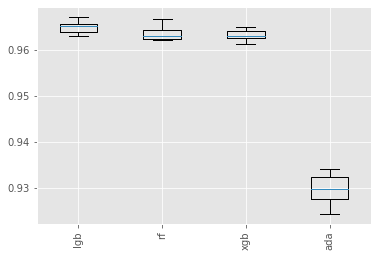

In [97]:
%%time
# get model list
models = define_models()
# evaluate models
results = evaluate_models(X_train, y_train, models)
# summarize results
summarize_results(results)

### Way 2 - Best Features

Defined 4 models
>ada: 0.88922 (+/-0.00155)
>rf: 0.89868 (+/-0.00242)
>lgb: 0.89880 (+/-0.00250)
>xgb: 0.89881 (+/-0.00249)

Rank=1, Name=xgb, Score=0.89881 (+/- 0.00249)
Rank=2, Name=lgb, Score=0.89880 (+/- 0.00250)
Rank=3, Name=rf, Score=0.89868 (+/- 0.00242)
Rank=4, Name=ada, Score=0.88922 (+/- 0.00155)
Wall time: 42.3 s


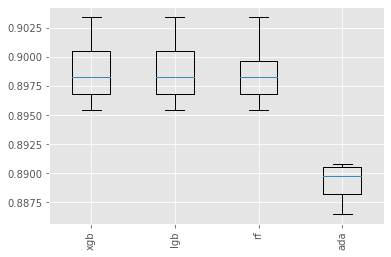

In [98]:
%%time 
# get model list
models = define_models()
# evaluate models
results = evaluate_models(X_fsel, y_train, models)
# summarize results
summarize_results(results)

The best 2 models are LightGBM and RandomForest on the entire dataset. We proceed to implement hyperparameter tuning on them.

<a id="5.2"></a>
## 5.2 Hyperparameter Tuning
[Back to Table of Content](#0)

Hyperparameters are parameter that pratictioners must set manually in order to customize the model to the data to help guide the learning process; in this they differ from parameters which are learned directly by the model during the traning process.
While the general effects of the single hyperparameter on a model is known, it is hard to know the interaction between different hyperparameter on a specific dataset. For this reason the process known as hyperparameter tuning is an important step in the machine learning pipeline. 

A range of different optimization algorithms can be used to optimize hyperparameters, although two of the simplest and most common methods are random search and grid search:
* **Random Search**. Define a search space as a bounded domain of hyperparameter values and randomly sample points in that domain.
* **Grid Search**. Define a search space as a grid of hyperparameter values and evaluate every position in the grid.

Grid search is great for combinations that are known to perform well generally. Random search work better discovering and getting hyperparameter combinations that would not have guessed intuitively, although it often requires more time to execute.
More advanced methods are sometimes used, such as Bayesian Optimization and Evolutionary Optimization.

Regardless of the hyperparameter search method used, the process consist to objectively search different values for model hyperparameters and choose a subset that results in a model that achieves the best performance on a given dataset.

We will use 3-fold cross validation which means training and testing the model with each set of hyperparameter values 3 times to assess performance.

We are facing a classification problem then we will use the Sciktilearn's StratifiedKFold method to separate the dataset in folds and RandomizedSearchCV to search on the dimension of the parameters space the vector containing the best combination.

In [99]:
# define stratified-kfold method
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

## Fine Tuning Random Forest Hyperparameters

#### Random Forest Hyperparameters we’ll be Looking at:

* **max_features**: The size of the random subsets of features to consider when splitting a node, i.e. the number of features selected at random and without replacement at each split. Increasing max_features generally improves the performance of the model as at each node now we have a higher number of options to be considered. However, this is not necessarily true as this decreases the diversity of individual. But, for sure, you decrease the speed of algorithm by increasing the max_features. Hence, you need to strike the right balance and choose the optimal max_features.
* **min_samples_leaf**: This Random Forest hyperparameter specifies the minimum number of samples that should be present in the leaf node after splitting a node. This parameter also control the growth of the tree by setting a minimum sample criterion for terminal nodes. Similar to the hyperparameters mentioned above, this hyperparameter also helps prevent overfitting as the parameter value increases.
* **n_estimators**: In general the more the trees the greater the performance . The drawback is that by choosing more number of trees, the time complexity of the model also increases, i.e. it is important to find the sutable number of trees that minimize complexity and maximise performance.

Steps of the hyperparameters tuning:
1. define the model
2. define the cross validation method, i.e. repeats for 3 times stratified 3-Fold (n_splits=3) cross validation with different randomization in each repetition.
3. define the search space:
    * max_features:
        * sqrt: square of n_features
        * log2: logarithm in base 2 of n_features
        * int: 13 features
    * min_samples_leaf:
         * int: 1 samples = default value
         * int: 5 samples
    * n_estimators: 1800, 2000 or 2200 trees
4. initialize the randomized search cross validation of the hyperparameters, i.e. we will make 15 iterations among the space of hyperparameters.
5. fit the randomsearch object to the data
6. print best score and best parameters

In [100]:
%%time

# define model
model_rf = RandomForestClassifier(random_state=1)

# define search space
space_rf = {'max_features': ['sqrt', 'log2', 0.5, 1.0],
            'min_samples_leaf': [1, 5],
            'n_estimators': [1800, 2000, 2200]
}

# define search
search_rf = RandomizedSearchCV(model_rf, space_rf, n_iter=5, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
# execute search
rf = search_rf.fit(X_train, y_train)
# summarize result
print(f'Best Score for rf: {rf.best_score_}\nBest Hyperparameters for rf: {rf.best_params_}')

Best Score for rf: 0.9636368896947033
Best Hyperparameters for rf: {'n_estimators': 2000, 'min_samples_leaf': 1, 'max_features': 0.5}
Wall time: 26min 48s


I create a list of all the models

In [101]:
models = list()
models.append(rf)

## Fine Tuning Light GBM Hyperparameters

#### LGBMClassifier Hyperparameters we’ll be Looking at:

* **boosting_type**: LightGBM supports a number of different boosting algorithms. The options include:
* gbdt: Gradient Boosting Decision Tree (GDBT). The default, is the classical gradient boosting algorithm.
* dart: Dropouts meet Multiple Additive Regression Trees (DART). DART stand for Dropouts Additive Regression Trees, it adds the concept of dropout from deep learning to the Multiple Additive Regression Trees (MART) algorithm, a precursor to gradient boosting decision trees.
* goss: Gradient-based One-Side Sampling (GOSS), seeks to only use instances that result in a large error gradient to update the model and drop the rest.

* **n_estimators**: Gradient Boosting is a squential algorithm, the weak learners, i.e. the single decision trees, are developed one after the other in an effort to correct and improve upon the predictions made by prior trees. As such, more trees is often better, with the same drawback we've seen for Random Forest , i.e. it is important to find the number of trees that minimize the complexity and maximise the performance.

Steps of the hyperparameters tuning:
1. define the model
2. define the search space
3. initialize the randomized search cross validation of the hyperparameters, i.e. we will make 20 iterations among the space of hyperparameters.
5. fit the randomsearch object to the data
6. print best score and best parameters

In [102]:
%%time

# define model
model_lgb = LGBMClassifier(random_state=1)

# define search space
# Hyperparameter grid
space_lgb = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'n_estimators': [500, 800, 1500, 2000] # number of trees
}

# define search
search_lgb = RandomizedSearchCV(model_lgb, space_lgb, n_iter=12,
                                scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
# execute search
lgb = search_lgb.fit(X_train, y_train)
# summarize result
print(f'Best Score for lgb: {lgb.best_score_}\nBest Hyperparameters for lgb: {lgb.best_params_}')

Best Score for lgb: 0.9651427737251362
Best Hyperparameters for lgb: {'n_estimators': 800, 'boosting_type': 'dart'}
Wall time: 7min 43s


In [103]:
models.append(lgb)

<a id="5.3"></a>
## 5.3 Evaluation of the models on the Test set
[Back to Table of Content](#0)

In this section we will applay the best trained models on the test dataset. We then benchmark the results and select the best one. Once we have chosen the best model, we will explore its behavior more in depth by analyzing the confusion matrix.

The process will follow the following steps:
1. prediction
3. benchmark the results and select the best model
4. analyze more in depth the behavior of the chosen model

### Prediction

Now we evaluate each model on the test data and consequently create a two dimensional data structure containing, for each model, the accuracy scores on the training and testing set

In [104]:
tab = []
for model in models:
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    acc_test = accuracy_score(y_test, test_pred)
    acc_train = accuracy_score(y_train, train_pred)

    tab.append([model.estimator, acc_train, acc_test])
    
table = pd.DataFrame(tab, columns=['model', 'acc_train', 'acc_test']).sort_values('acc_test', ascending=False)
table

,model,acc_train,acc_test
1,LGBMClassifier(random_state=1),0.972913,0.965821
0,RandomForestClassifier(random_state=1),1.000000,0.964701


RandomForestClassifier overfit training data but get also a good accuracy on testing data; the best model is LGBMClassifier, we will examin its behavior more in deep.

### Best Model in depth

**Confusion Matrix** is a usefull instrument to visualize the result of the prediction. It is a matrix were each row represents the instances in the actual class and the columns represent the instances in the predicted class (scikit-learn format). Looking at the confusion matrix, we can clearly see what is the performance of the classifier on correctly predicting the positive and negative class.

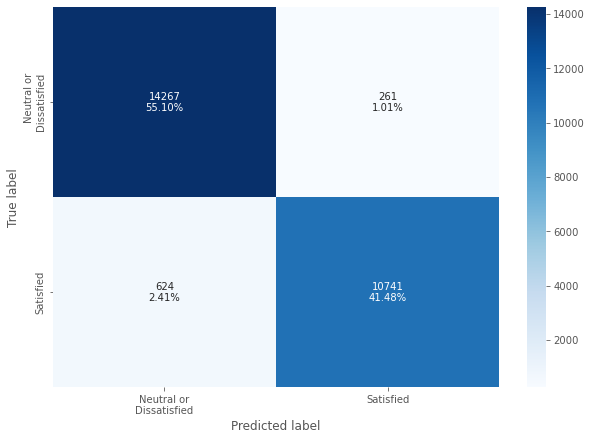

In [105]:
cm = confusion_matrix(y_test, test_pred, labels=[0, 1]) # make the confucion matrix

# crate a dataframe from the cm
df_cm = pd.DataFrame(cm, index = [i for i in ['Neutral or\nDissatisfied','Satisfied']],
              columns = [i for i in ['Neutral or\nDissatisfied','Satisfied']])

# calculate count for each class
group_counts = [f'{value:0.0f}' for value in cm.flatten()]

# calculate % of each class respect to all samples
group_percentages = [f'{value:.2%}' for value in cm.flatten() / np.sum(cm)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# plot the confusion matrix as an heatmap
plt.figure(figsize = (10, 7))
sns.heatmap(df_cm, annot=labels, fmt='', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

The model correctly classified 14267 samples out of a total of 14528 of the negative class by incorrectly classifying 261 samples (False Positive = people that were actually unsatisfied being predicted satisfied) equal to 1.01% of all samples; furthermore has correctly classified 10741 samples of the positive class out of a total of 11365, incorrectly classifying 624 samples (False Negative= people that were actually satisfied being predicted unsatisfied) equal to 2.41% of all samples.

<a id="6"></a>
# 6. Features Importance

[Back to Table of Content](#0)

When examining the importance of features by a model, it is important to keep in mind that these estimates are what the model "thinks" about the features and dataset, and unless the model is a perfect predictor, they will not be however correct.

Two types of feature importance can be extracted from LightGBM:
* gain -  total gains of splits which use the feature, similar to Random Forest features importance method
* split - the number of times a feature is used to split the data across all trees


Since the gain method measures directly how much a feature contributes to the loss reduction, we plot features importance with the 'gain' method.

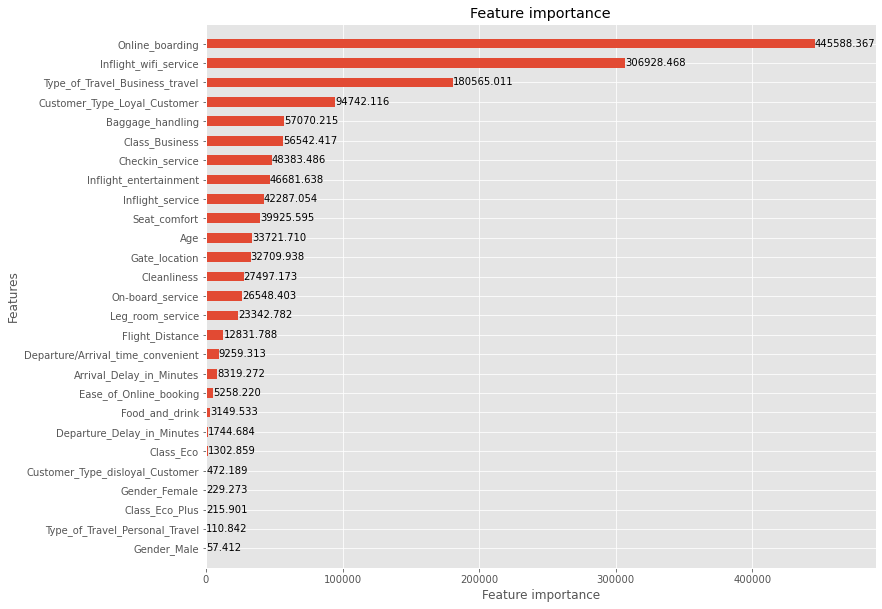

In [106]:
import lightgbm
fig, ax = plt.subplots(figsize=(12, 10))

lightgbm.plot_importance(lgb.best_estimator_, importance_type='gain' , height=0.5, ax=ax)
plt.savefig('feat_imp_lgb', bbox_inches='tight')

We can see that results are quite similar to those we reached in the Features Selection step, i.e. the first most informative 2 features are Online_boarding and Inflight_wifi_service; while the third most informative for us was Class_Business for the model is Type_of_Travel_Business travel which were the forth for us.
What surprised me is Baggage Handling that the model consider much more informative respect to what the result of the features selection yield.

<a id="7"></a>
# 7. Conclusion
[Back to Table of Content](#0)

Our tuned LightGBMClassifier looks like a very accurate model with an accuracy of 96.6% on the test set.

For the final prediction we used the model trained on all the features as the models that trained on  the best 4 features turned out to be more inefficient; perhaps because passenger satisfaction strongly depends on many features of the dataset, as we have also seen for the ranking of the features importance of the model, from which we can see that the first 4 features are very important compared to the others but that still provide a certain level of information.

By looking at the visualizations and feature importances of the model, as intuited in the exploratory phase, services that affect satisfaction the most are:
* Online boarding
* Inflight wifi service

Then we have less informative but also important service as:
* Bagagge handling
* Inflight entertainment
* Checkin service
* Seat comfort
* Cleanliness
* Gate location

The Gate location and the Departure / Arrival time convenient deserve a separate mention, which in the exploration phase resulted not very influential with respect to the level of passenger satisfaction. We can now confirm what was expected for the last one, but as regards Gate location it seems that for the model it has a certain importance even higher than Cleanliness. In general, however, as regards the services, those considered most important are confirmed to be Online boarding and Inflight wifi service as well as in general the services on board. I was also surprised by Bagagge_handling which, compared to what was seen in the EDA phase, for the prediction appears to have a greater weight.

Furthermore, we can say that:

* The majority of personal travel passengers are not satisfied, incentive campaigns can be organized for them.

* While the business class passengers are generally satisfied, the majority of the eco class passengers are not. Extra services can be added for eco class.